# Industrial Applications of Artificial Intelligence - Predictive Maintenance

### This notebook is part of the second hand-in regarding the secondary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Industrial companies rely heavily on the machines that operate within their assembly lines. Even the slighest error that would cause the line to be stopped will result in losses of serveral hundred to thousands of euros. In 2015, insiders calculated that one minute of downtime, costs Daimler, BMW and AUDI between 1000€ and 6000€ [(src)](https://www.dvz.de/rubriken/logistik/it-in-der-logistik/detail/news/geruestet-fuer-den-blackout.html#:~:text=Denn%20eine%20Minute%20Bandstillstand%20bei,zwischen%201000%20und%206000%20EUR.). Due to rising competition in a global economy, predictive maintenance becomes a crucial task to not lose money and time in operations, because a company is able to prevent breakdowns with early countermeasures. The challenge arises for the company to prevent components from being replaced too early in the lifecycle and still ensuring reliability. Machine Learning can help in this task. By making use of data from the machines itself and sensors in the surrounding, companies are able to plan ahead and schedule actions to keep their assembly line healthy. One possible way to do this, is modelling the failure/non-failure of a machine as a binary classification. In the following, we want to explore how to preprocess a related dataset and how models are able to support companies in recognizing a failure or not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,StratifiedKFold
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import itertools
from skopt import BayesSearchCV
from skopt.space import Real, Integer

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## I. Data Exploration

The dataset can be found on kaggle unter the following [URL](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification?select=predictive_maintenance.csv). Since real data is in most cases a secret companies hide in order not to give an advantage to the competition, we use a synthetically generated dataset that can be found on Kaggle that reflects real predictive maintenance encountered in industry. The [dataset](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset ) was published by the Center for Machine Learning and Intelligent Systems of the University of California. First of all, the dataset consists out of 10,000 entries containing eight features and two targets, which will be described in the following.
* UDI: Unique identifier having the same value as the corresponding index.
* Product ID: Combination of a letter and a 4-digit serial number. The value of the letter reflects the quality of the product, where L stands for low, M for medium and H for high.
* Type: Again reflects the quality of the product in the same manner as the product ID with L, M, H.
* Air temperature [K]: Reflects the temperature of the surrounding air measured in Kelvin (0°C = 173,15 K).
* Process temperature [K]: Measures the temperature within the process/machine in Kelvin.
* Rotational speed [rpm]: Corresponds to the rotation speed of the machine measured revolutions per minute .
* Torque [Nm]: Moment of force, rotational force in Newtonmeter. Rotational equivalent to linear force.
* Tool wear [min]: Gradual failure of tools due to regular operation. Depending on quality of the product, it adds different minutes to the used tool (H/M/L -> 5/3/2 minutes). So, the value is reseted to zero, if the machine has been changed.
* Target: Binary. Failure(1), Non-Failure (0)
* Failure Type

In [2]:
dir_path ='../../src/data/Abgabe_2/'
df = pd.read_csv(os.path.join(dir_path, "predictive_maintenance.csv"))
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


During the training, we noticed that some algorithms, in particular XGBoost, cannot cope with specific values in the feature names of our dataframe (in our case "[ ]". So, we will clean this up in the beginning for the whole table.

In [3]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
df.head(10)

,UDI,Product ID,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


Since we already know that UDI is always the same value as the index +1, we discard the column.

In [4]:
df = df.drop(columns=['UDI'])
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,10000.00,300.00,2.00,295.30,298.30,300.10,301.50,304.50
Process temperature K,10000.00,310.01,1.48,305.70,308.80,310.10,311.10,313.80
Rotational speed rpm,10000.00,1538.78,179.28,1168.00,1423.00,1503.00,1612.00,2886.00
Torque Nm,10000.00,39.99,9.97,3.80,33.20,40.10,46.80,76.60
Tool wear min,10000.00,107.95,63.65,0.00,53.00,108.00,162.00,253.00
Target,10000.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00


In [5]:
df.isna().sum()

Product ID               0
Type                     0
Air temperature K        0
Process temperature K    0
Rotational speed rpm     0
Torque Nm                0
Tool wear min            0
Target                   0
Failure Type             0
dtype: int64

Since we have a synthetical dataset, we do not have any NA values. So, we do not need to further preprocess the data in that regard. In the following, we will also discard the failure type, as we want to focus on the binary classification of failure/non-failure. Including the failure type column as a feature to the algorithm would be a false predictor, as it would spoil the label since no-failure does always correspond to 0 in the target.

In [6]:
df = df.drop(columns=['Failure Type'])

After dropping the column, we will again look at our data to decide whether we have to scale it or not.

In [7]:
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,10000.00,300.00,2.00,295.30,298.30,300.10,301.50,304.50
Process temperature K,10000.00,310.01,1.48,305.70,308.80,310.10,311.10,313.80
Rotational speed rpm,10000.00,1538.78,179.28,1168.00,1423.00,1503.00,1612.00,2886.00
Torque Nm,10000.00,39.99,9.97,3.80,33.20,40.10,46.80,76.60
Tool wear min,10000.00,107.95,63.65,0.00,53.00,108.00,162.00,253.00
Target,10000.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00


We see that our scales for the different features, differ a lot. That could possibly have a big impact on the algorithms' performances. However, we do not want to do that on all the data, but rather fit the scaler only on the train data and use it on test and validation. So, we will come back to that after the train-test-split.

In a next step, we will dive deeper into the different distributions of column values. However, before we do that, we will get rid of the letter in the product ID, as we always have that in the type column already.

In [8]:
# we strip the letters from the numbers and use only the numbers for the Product ID
df['Product ID'] = df['Product ID'].apply(lambda row: int(''.join(filter(str.isdigit, row))))

In [9]:
df.head(10)

,Product ID,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target
0,14860,M,298.1,308.6,1551,42.8,0,0
1,47181,L,298.2,308.7,1408,46.3,3,0
2,47182,L,298.1,308.5,1498,49.4,5,0
3,47183,L,298.2,308.6,1433,39.5,7,0
4,47184,L,298.2,308.7,1408,40.0,9,0
5,14865,M,298.1,308.6,1425,41.9,11,0
6,47186,L,298.1,308.6,1558,42.4,14,0
7,47187,L,298.1,308.6,1527,40.2,16,0
8,14868,M,298.3,308.7,1667,28.6,18,0
9,14869,M,298.5,309.0,1741,28.0,21,0


In [10]:
# we still see that we have no duplicate numbers
df['Product ID'].nunique()

10000

We can still see that we do not have any duplicates in our column. So, the ID does not offer any further information in our downstream tasks. So, we discard this column as it has a 1:1 relationship to our index.

In [11]:
df = df.drop(columns=['Product ID'])

We will now have a look at different columns to see how they are distributed.

<AxesSubplot:title={'center':'Distribution of product types'}>

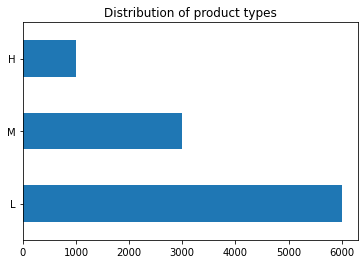

In [22]:
df['Type'].value_counts().plot(kind ='barh', title='Distribution of product types')

We can see that most of the products are of the lowest category and therefore, add the most minutes to tool wear and are responsible for the highest abrasion of the machine. We have to keep that in mind, as tool wear can have a huge influence on the our machine. We further have a look into the two temperature features.

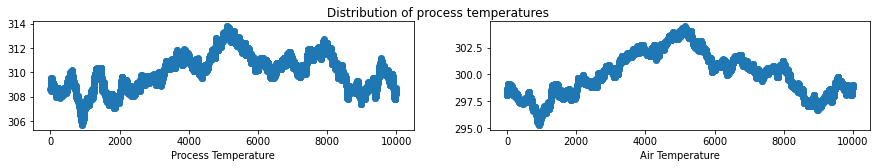

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15,2))
fig.suptitle('Distribution of temperatures')
ax1.scatter(df.index, df['Process temperature K'])
ax1.set_xlabel('Process Temperature')
ax2.scatter(df.index, df['Air temperature K'])
ax2.set_xlabel('Air Temperature')
plt.show()

We can see that both temperatures follow the typical structure of a random walk that was used to create those values synthetically. We have to keep that in mind for our further work, as that might have issues regarding the meaningfulness of the features.

On top of that, we currently have two categorical features. For the algorithms to be able to work with them in the downstream tasks, we will one-hot encode them. 

In [20]:
# encode type as last remaining categorical feature
categorical_features = ['Type']
encoder = OneHotEncoder()
#create encoded dataframe
encoded = pd.DataFrame(encoder.fit_transform(df[categorical_features]).toarray(), columns=encoder.get_feature_names(categorical_features))
df_ohe = df.drop(columns=categorical_features).join(encoded)
df_ohe.head(10)

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0.0,0.0,1.0
1,298.2,308.7,1408,46.3,3,0,0.0,1.0,0.0
2,298.1,308.5,1498,49.4,5,0,0.0,1.0,0.0
3,298.2,308.6,1433,39.5,7,0,0.0,1.0,0.0
4,298.2,308.7,1408,40.0,9,0,0.0,1.0,0.0
5,298.1,308.6,1425,41.9,11,0,0.0,0.0,1.0
6,298.1,308.6,1558,42.4,14,0,0.0,1.0,0.0
7,298.1,308.6,1527,40.2,16,0,0.0,1.0,0.0
8,298.3,308.7,1667,28.6,18,0,0.0,0.0,1.0
9,298.5,309.0,1741,28.0,21,0,0.0,0.0,1.0


In a last preprocessing step, we will deeper investigate collreation of features and drop a feature if it has a correlation of more than 0.8 to one of the other features (excluding the target).

In [21]:
def drop_correlated_features(df:pd.DataFrame, thr:float) -> pd.DataFrame:
    """
    Function to detect all correlated features
    :param df: general dataframe
    :param thr: threshold for the correlation param
    :return: dataframe without correlated features
    """
    correlated_features = set()
    correlation_matrix = df.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > thr:
                print(
                    f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]), 2)}")
                colname = correlation_matrix.columns[j]
                correlated_features.add(colname)
    print(f"Drop the following features: {correlated_features}")
    # drop correlated features
    df = df.drop(columns=correlated_features)

    return df

C:\Users\Nikla\AppData\Local\Temp\ipykernel_5400\3025600473.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


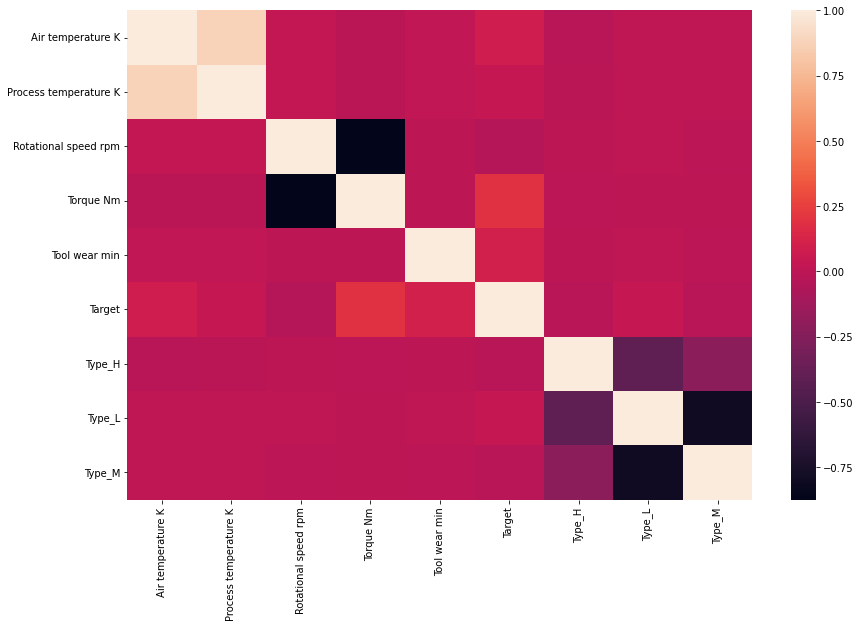

In [22]:
# investigate correlation heatmap
corrMatrix=df_ohe.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [23]:
#drop target to not use it in the correlations of the explanatory variables
df_target = df_ohe['Target']
df_cor = df_ohe.drop(columns=['Target'])
# drop highly correlated features
df_cor = drop_correlated_features(df_cor, 0.8)

The following features are correlated: Process temperature K and Air temperature K. Correlation = 0.88
The following features are correlated: Torque Nm and Rotational speed rpm. Correlation = 0.88
The following features are correlated: Type_M and Type_L. Correlation = 0.8
Drop the following features: {'Rotational speed rpm', 'Air temperature K', 'Type_L'}


In a last step, we will again concatenate the target column to our dataframe.

In [24]:
df_preprocessed = pd.concat([df_cor, df_target], axis=1)
df_preprocessed.head(5)

,Process temperature K,Torque Nm,Tool wear min,Type_H,Type_M,Target
0,308.6,42.8,0,0.0,1.0,0
1,308.7,46.3,3,0.0,0.0,0
2,308.5,49.4,5,0.0,0.0,0
3,308.6,39.5,7,0.0,0.0,0
4,308.7,40.0,9,0.0,0.0,0


We are now done with preprocessing and will create a train-test split in the following that can be used in downstream tasks.

# II. Train-Test-Split

Since we do not have a given split up into train, test and validation, we will create that in the following. We will therefore split our given data into 60% train, 20% val and 20% test. Before we do that, we will have a short look on the distribution of our target to check for an imbalanced set.

<AxesSubplot:>

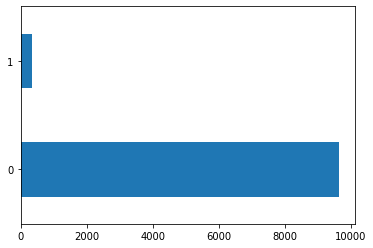

In [25]:
df_preprocessed['Target'].value_counts().plot(kind ='barh')

In [26]:
df_preprocessed['Target'].value_counts()

0    9661
1     339
Name: Target, dtype: int64

We can clearly see that we have an highly unbalanced dataset and therefore need to make sure to include all classes in our splitted sets via stratified sampling. The imbalance is also an indicator to use the f1-score as metric for our further downstream task instead of the accuracy, as accuracy would deliver a good result for not predicting the minor class at all. We will also keep the test set completely out of all steps except the last predicition to see how good our best model generalizes.

In [27]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['Target']), df_preprocessed['Target'], test_size=0.2, random_state=42, stratify=df_preprocessed['Target'])

In [28]:
#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

We will now have a look at the values in our different sets to check wether the distribution of the target is nearly the same.

In [29]:
# define values for plots
x = ['0','1']
y_train = target_train.value_counts().to_list()
y_val = target_val.value_counts().to_list()
y_test = target_test.value_counts().to_list()

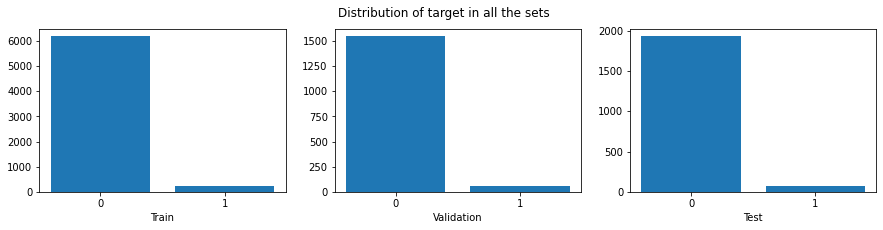

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(15,3))
fig.suptitle('Distribution of target in all the sets')
ax1.bar(x, y_train)
ax1.set_xlabel('Train')
ax2.bar(x, y_val)
ax2.set_xlabel('Validation')
ax3.bar(x, y_test)
ax3.set_xlabel('Test')
plt.show()

We can clearly see that the distribution is nearly the same for all our sets. As we generated the train-test-validation split in the previous step, we now want to scale the data as described earlier. This is for the reason, that different scales might actually distort our algorithm a lot due to big differences in the scales. For scaling, we use the StandardScaler from the sklearn package. It should be noted that we only fit the scaler on our training data and use only the transformation on the validation and testing part, because we do not want to include information about validation and test that could already help the algorithm (data leakage).

In [31]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['Process temperature K','Torque Nm','Tool wear min', 'Process temperature K' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [32]:
data_train.head(5)

,Process temperature K,Torque Nm,Tool wear min,Type_H,Type_M
8204,0.605754,-1.218791,-1.524967,0.0,0.0
8372,-0.206288,0.480406,-1.195608,0.0,1.0
292,-1.086000,0.020623,0.027726,0.0,0.0
4460,0.335073,-0.719027,1.345163,0.0,0.0
6499,-0.003278,-1.318744,1.439265,0.0,0.0


In [33]:
data_val.head(5)

,Process temperature K,Torque Nm,Tool wear min,Type_H,Type_M
1267,-0.273958,-0.129306,-1.007403,0.0,1.0
5085,2.026827,1.599876,-0.725095,0.0,1.0
440,-1.018330,-0.079330,-0.834881,0.0,0.0
3445,0.402743,-0.389183,1.580419,0.0,1.0
1693,-1.695032,-1.218791,-1.274027,1.0,0.0


In [34]:
data_test.head(5)

,Process temperature K,Torque Nm,Tool wear min,Type_H,Type_M
2997,-0.138618,2.269560,0.717812,0.0,0.0
4871,1.620806,0.010628,0.435504,0.0,0.0
3858,0.944104,-0.239254,1.596103,0.0,0.0
951,-2.507073,-0.419169,-0.740779,1.0,0.0
6463,-0.003278,2.039668,-0.082060,1.0,0.0


After scaling the data, we can now continue with our baseline.

# III. Baseline

Our baseline will be an easy prediction using only the majority class for our validation set. Therefore all our values will be set to 0. Since we want to get the f1-score weighted over all classes, we use the macro averaged one to better understand the performance.

In [35]:
prediction = np.zeros(len(target_val))
acc = accuracy_score(target_val,prediction) 
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("The Accuracy on the validation set: {:.4f}".format(acc))
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

The Accuracy on the validation set: 0.9663
The F1-Score on the validation set: 0.4914
The Precision on the validation set: 0.4831
The Recall on the validation set: 0.5000
Confusion Matrix : 
[[1546    0]
 [  54    0]]


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can clearly see that our model is not good, as we are only predicting the major class. However, as already indicated, one could also see that we do have a pretty high accuracy, as our dataset is extremly imbalanced, as failures occur normally far less than no failures. That is the reason, why accuracy is not a good measure in our case and we will focus on the f1-score.

# IV. Modelling

In the following, we will first try out some models and see how they behave with their default values, afterwards we will focus on 1 model for extensive training to achieve better results. We will try to maximize our f1, as a combination of precision and recall. Both are important, as it is critical to detect failures as fast as possible (maximization of recall for the smaller class), but also be precise as possible to prevent unnecessary work, as an ingenieur needs to check possible failures. Therefore, we use the f1-score to focus on both precision and recall.

We first define a stratified fold to make sure that the distribution during the cv splits stays the same.

In [36]:
cv_stratified = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

### Logistic Regression

In [37]:
lr = LogisticRegression()
cross_val=cross_val_score(lr, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
lr.fit(data_train,target_train)
prediction = lr.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.5351
The F1-Score on the validation set: 0.5098
The Precision on the validation set: 0.9834
The Recall on the validation set: 0.5093
Confusion Matrix : 
[[1546    0]
 [  53    1]]


### SVM

In [38]:
svc = SVC()
cross_val=cross_val_score(svc, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
svc.fit(data_train,target_train)
prediction = svc.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.6340
The F1-Score on the validation set: 0.7079
The Precision on the validation set: 0.9564
The Recall on the validation set: 0.6386
Confusion Matrix : 
[[1545    1]
 [  39   15]]


### Naive Bayes

In [39]:
nb=GaussianNB()
cross_val=cross_val_score(nb, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
nb.fit(data_train,target_train)
prediction = nb.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.5831
The F1-Score on the validation set: 0.6333
The Precision on the validation set: 0.9358
The Recall on the validation set: 0.5830
Confusion Matrix : 
[[1545    1]
 [  45    9]]


### Random Forest

In [40]:
rf = RandomForestClassifier()
cross_val=cross_val_score(rf, data_train, target_train, cv=cv_stratified,scoring='f1_macro')
rf.fit(data_train, target_train)
prediction = rf.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.7486
The F1-Score on the validation set: 0.8083
The Precision on the validation set: 0.9394
The Recall on the validation set: 0.7398
Confusion Matrix : 
[[1543    3]
 [  28   26]]


### XGBoost

In [41]:
xgb = XGBClassifier()
cross_val=cross_val_score(xgb, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
xgb.fit(data_train, target_train)
prediction = xgb.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

[10:03:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[10:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:03:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-average F1-score: 0.7515
The F1-Score on the validation set: 0.7828
The Precision on the validation set: 0.8522
The Recall on the validation set: 0.7375
Confusion Matrix : 
[[1536   10]
 [  28   26]]


### MLP Classifier

In [42]:
mlp=MLPClassifier()
cross_val=cross_val_score(mlp, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
mlp.fit(data_train,target_train)
prediction = mlp.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


CV-average F1-score: 0.7338
The F1-Score on the validation set: 0.7574
The Precision on the validation set: 0.9438
The Recall on the validation set: 0.6845
Confusion Matrix : 
[[1544    2]
 [  34   20]]


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


We have now fitted some models and see the scores with 5-fold cross-validation on our training data. We can clearly see, that all the models perform better than our baseline with random forest, xgboost and the multi-layer perceptron performing far better than the rest. That was expected, as those models are already more sophisticated due to ensemble methods and MLP more intensive as neural network than naive bayes, logistic regression and support vector classification.

However, we can see the models make different mistakes. So, it can be useful to combine them in an ensemble strategy (voting ensemble with majority vote).

In [43]:
lr = LogisticRegression()
nb=GaussianNB()
svc = SVC()
rf = RandomForestClassifier()
xgb = XGBClassifier()
mlp=MLPClassifier()


vo_cl = VotingClassifier([ ('nb', nb),('svc',svc), ('rf',rf), ('xgb',xgb), ('mlp',mlp)])
cross_val=cross_val_score(vo_cl, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
vo_cl.fit(data_train, target_train)
prediction = vo_cl.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:04:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your 

[10:04:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index

[10:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index

[10:04:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your 

[10:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index

[10:04:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CV-average F1-score: 0.7038
The F1-Score on the validation set: 0.7671
The Precision on the validation set: 0.9461
The Recall on the validation set: 0.6938
Confusion Matrix : 
[[1544    2]
 [  33   21]]


After using a lot of different settings, it seems that the voting ensemble gets mostly dominated by the best classifier from the earlier stage and there is no real improvement compared to XGBoost as our best model.

We will now test a setting where we keep the correlated features for our best models, in particular XGBoost, Random Forest and the MLP Classifier. Per default, those models should be able to handle correlated data instead of some other algorithms. And as they are already far better than the other models, we will focus on them in the following.

# V. RF, XGBoost and MLP with correlated features

We will start our pipeline after the one-hot encoding step in cell 12 and omit the dropping of correlated features to see how our models behave with highly correlated features.

In [44]:
df_ohe.head(10)

,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0.0,0.0,1.0
1,298.2,308.7,1408,46.3,3,0,0.0,1.0,0.0
2,298.1,308.5,1498,49.4,5,0,0.0,1.0,0.0
3,298.2,308.6,1433,39.5,7,0,0.0,1.0,0.0
4,298.2,308.7,1408,40.0,9,0,0.0,1.0,0.0
5,298.1,308.6,1425,41.9,11,0,0.0,0.0,1.0
6,298.1,308.6,1558,42.4,14,0,0.0,1.0,0.0
7,298.1,308.6,1527,40.2,16,0,0.0,1.0,0.0
8,298.3,308.7,1667,28.6,18,0,0.0,0.0,1.0
9,298.5,309.0,1741,28.0,21,0,0.0,0.0,1.0


In a first step, we split up the data again.

In [45]:
df_preprocessed = df_ohe

# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['Target']), df_preprocessed['Target'], test_size=0.2, random_state=42, stratify=df_preprocessed['Target'])

#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

Since we haven't scaled the features yet, we will make use of the same scaler method again.

In [46]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['Process temperature K','Torque Nm','Tool wear min', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In the following, we will test the sets with our three best previous model and decide if we want to keep the features or not.

We first define a stratified fold to make sure that the distribution during the cv splits stays the same.

In [47]:
cv_stratified = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

### Random Forest

In [48]:
rf = RandomForestClassifier()
cross_val=cross_val_score(rf, data_train, target_train, cv=cv_stratified,scoring='f1_macro')
rf.fit(data_train, target_train)
prediction = rf.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.7758
The F1-Score on the validation set: 0.8330
The Precision on the validation set: 0.9745
The Recall on the validation set: 0.7589
Confusion Matrix : 
[[1545    1]
 [  26   28]]


### XGBoost

In [49]:
xgb = XGBClassifier()
cross_val=cross_val_score(xgb, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
xgb.fit(data_train, target_train)
prediction = xgb.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

[10:04:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[10:04:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:04:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-average F1-score: 0.8723
The F1-Score on the validation set: 0.8644
The Precision on the validation set: 0.9207
The Recall on the validation set: 0.8221
Confusion Matrix : 
[[1540    6]
 [  19   35]]


### MLP Classifier

In [50]:
mlp=MLPClassifier()
cross_val=cross_val_score(mlp, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
mlp.fit(data_train,target_train)
prediction = mlp.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_pe

CV-average F1-score: 0.7962
The F1-Score on the validation set: 0.8288
The Precision on the validation set: 0.9584
The Recall on the validation set: 0.7586
Confusion Matrix : 
[[1544    2]
 [  26   28]]


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


If we have a look at the average cross-validation score, we can see that XGBoost, Random Forest and the MLP improve a lot. So, the impact of the features outweigh the negative impact of a possible correlation. This could be expected as tree-based models and neural networks can normally cope with correlated features. Therefore, we will proceed without dropping the features. In the following, since XGBoost is outperforming our other models by up to more than 5% already, we will continue to focus on the algorithm and include the MLP for comparison.

# V. Feature Generation

We now want to have a look at the data itself to understand if we are able to achieve better performances by engineering further features. We use again the pipeline without dropping the correlated features from chapter I and II.

In [51]:
# look at distribution
df[df.Target == 0].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,9661.00,299.97,1.99,295.30,298.30,300.00,301.50,304.50
Process temperature K,9661.00,310.00,1.49,305.70,308.80,310.00,311.10,313.80
Rotational speed rpm,9661.00,1540.26,167.39,1168.00,1429.00,1507.00,1615.00,2695.00
Torque Nm,9661.00,39.63,9.47,12.60,33.10,39.90,46.30,70.00
Tool wear min,9661.00,106.69,62.95,0.00,52.00,107.00,160.00,246.00
Target,9661.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [52]:
# look at distribution
df[df.Target == 1].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,339.00,300.89,2.07,295.60,299.10,301.60,302.50,304.40
Process temperature K,339.00,310.29,1.36,306.10,309.50,310.40,311.20,313.70
Rotational speed rpm,339.00,1496.49,384.94,1181.00,1326.50,1365.00,1421.50,2886.00
Torque Nm,339.00,50.17,16.37,3.80,45.95,53.70,61.20,76.60
Tool wear min,339.00,143.78,72.76,0.00,84.50,165.00,207.50,253.00
Target,339.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


Based on the distributions, we can see that the mean of tool wear and torque are a lot higher for failures than for non-failures. Our first assumption is that for high tool wear values, a failure is more likely to happen, as the machine was used a lot and shows abrasion. On top of that, if the tool is set under stress with force, a crash is more likely to happen if the tool wear is already high. We have a further look into the distributions.

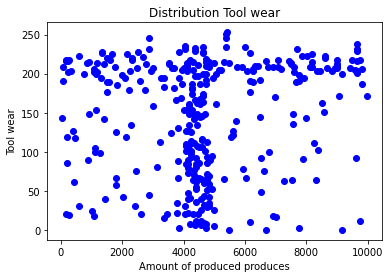

In [53]:
plt.scatter(df[df.Target == 1].index, df[df.Target == 1]['Tool wear min'], color='b')
plt.title('Distribution Tool wear')
plt.xlabel('Amount of produced produces')
plt.ylabel('Tool wear')
plt.show()

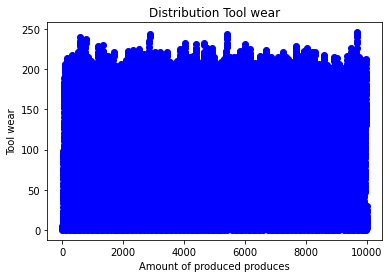

In [54]:
plt.scatter(df[df.Target == 0].index, df[df.Target == 0]['Tool wear min'], color='b')
plt.title('Distribution Tool wear')
plt.xlabel('Amount of produced produces')
plt.ylabel('Tool wear')
plt.show()

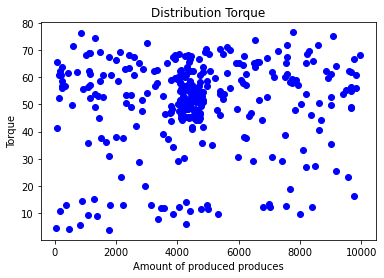

In [55]:
plt.scatter(df[df.Target == 1].index, df[df.Target == 1]['Torque Nm'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

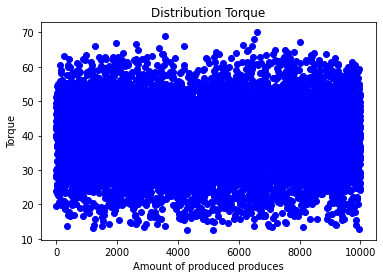

In [56]:
plt.scatter(df[df.Target == 0].index, df[df.Target == 0]['Torque Nm'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

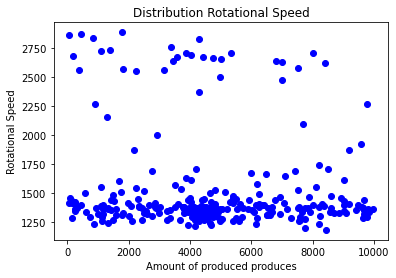

In [57]:
plt.scatter(df[df.Target == 1].index, df[df.Target == 1]['Rotational speed rpm'], color='b')
plt.title('Distribution Rotational Speed')
plt.xlabel('Amount of produced produces')
plt.ylabel('Rotational Speed')
plt.show()

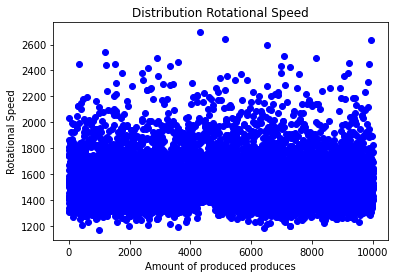

In [58]:
plt.scatter(df[df.Target == 0].index, df[df.Target == 0]['Rotational speed rpm'], color='b')
plt.title('Distribution Rotational Speed')
plt.xlabel('Amount of produced produces')
plt.ylabel('Rotational Speed')
plt.show()

The distributions show that our assumptions are correct with respect to torque and tool wear, but not with respect to rotational speed. We will see if we can improve our results by inserting a binary variable to indicate if torque is above 45-50 and simultaneously tool wear above 180-200.

In [59]:
df['tool_wear_torque_high'] = 0

In [60]:
df.loc[((df['Tool wear min'] > 199)&(df['Torque Nm'] > 45)), 'tool_wear_torque_high'] = 1

We will again prepare the data and train our models to see if we can improve.

In [61]:
# encode type as last remaining categorical feature
categorical_features = ['Type']
encoder = OneHotEncoder()
#create encoded dataframe
encoded = pd.DataFrame(encoder.fit_transform(df[categorical_features]).toarray(), columns=encoder.get_feature_names(categorical_features))
df_ohe = df.drop(columns=categorical_features).join(encoded)
df_ohe.head(10)

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,tool_wear_torque_high,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0.0,0.0,1.0
1,298.2,308.7,1408,46.3,3,0,0,0.0,1.0,0.0
2,298.1,308.5,1498,49.4,5,0,0,0.0,1.0,0.0
3,298.2,308.6,1433,39.5,7,0,0,0.0,1.0,0.0
4,298.2,308.7,1408,40.0,9,0,0,0.0,1.0,0.0
5,298.1,308.6,1425,41.9,11,0,0,0.0,0.0,1.0
6,298.1,308.6,1558,42.4,14,0,0,0.0,1.0,0.0
7,298.1,308.6,1527,40.2,16,0,0,0.0,1.0,0.0
8,298.3,308.7,1667,28.6,18,0,0,0.0,0.0,1.0
9,298.5,309.0,1741,28.0,21,0,0,0.0,0.0,1.0


In a last step, we will again concatenate the target column to our dataframe.

In [62]:
df_preprocessed = df_ohe
df_preprocessed.head(5)

,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,tool_wear_torque_high,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0.0,0.0,1.0
1,298.2,308.7,1408,46.3,3,0,0,0.0,1.0,0.0
2,298.1,308.5,1498,49.4,5,0,0,0.0,1.0,0.0
3,298.2,308.6,1433,39.5,7,0,0,0.0,1.0,0.0
4,298.2,308.7,1408,40.0,9,0,0,0.0,1.0,0.0


In [63]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['Target']), df_preprocessed['Target'], test_size=0.2, random_state=42, stratify=df_preprocessed['Target'])

In [64]:
#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

In [65]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['Process temperature K','Torque Nm','Tool wear min', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [58]:
xgb = XGBClassifier()
cross_val=cross_val_score(xgb, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
xgb.fit(data_train, target_train)
prediction = xgb.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[15:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[15:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-average F1-score: 0.8530
The F1-Score on the validation set: 0.8575
The Precision on the validation set: 0.9186
The Recall on the validation set: 0.8129
Confusion Matrix : 
[[1540    6]
 [  20   34]]


### MLP Classifier

In [59]:
mlp=MLPClassifier()
cross_val=cross_val_score(mlp, data_train, target_train, cv=cv_stratified, scoring='f1_macro')
mlp.fit(data_train,target_train)
prediction = mlp.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_pe

CV-average F1-score: 0.8140
The F1-Score on the validation set: 0.8466
The Precision on the validation set: 0.9058
The Recall on the validation set: 0.8033
Confusion Matrix : 
[[1539    7]
 [  21   33]]


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Unfortunately, after testing a lot of different settings regarding the threshold values and also experimenting with rotational speed and combinations with torque and tool wear, we were not able to generate a feature that improves our best algorithm XGBoost. The MLP Classifier improves by around ~1-2%, but still falls short to XGBoost. We can see in the distribution of train and validation, that there is no real, directly spotted delimitation between the different values. So, it seems that our assumption if the tool is set under stress with force (torque), a crash is more likely to happen if the tool wear is already high, may hold, but does not offer more value to our algorithms. Therefore, due to Occam's Razor, we drop the attribute again since we will focues on XGBoost for further hyperparameter tuning.

In [66]:
data_train = data_train.drop(columns=['tool_wear_torque_high'])
data_val = data_val.drop(columns=['tool_wear_torque_high'])
data_test = data_test.drop(columns=['tool_wear_torque_high'])
df = df.drop(columns=['tool_wear_torque_high'])

# VI. Hyperparameter tuning

For hyperparameter tuning, we will focus on our best model so far, in particular XGBoost. We will use a grid search to search the space of possible hyperparameter to gain the best possible result. In a first step, we define a parameter grid for XGBoost that can be used inside grid search for testing the best model. Since a grid search is computationally expensive, we also use bayesian search as a form of probabilistic model that keeps track of evaluation results by updating a “surrogate” for the objective function, which works much faster due to fact that they choose the next hyperparameters in an informed manner. 

In [ ]:
random_grid = { #6480 fits -> takes about ne hour
        'n_estimators': [50,100,150],
        'gamma': [0,0.1,0.5],
        'max_depth': [5,6,7,8],
        'min_child_weight': [1,2,5],
        'subsample': [0.9,1.0],
        'colsample_bytree': [0.9,1.0],
        'learning_rate': [0.2,0.3,0.4]
        }
xgb = XGBClassifier()
#define a stratified cross validation, as our data is highly imbalanced
cv_stratified = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
# Random search of parameters, using 5 fold cross validation
xgb_random = GridSearchCV(xgb, random_grid, cv=cv_stratified, scoring ='f1_macro', verbose=2, refit=True)
# Fit the random search model
xgb_random.fit(data_train, target_train)

In [63]:
best_random = xgb_random.best_estimator_
best_random.fit(data_train, target_train)
prediction = best_random.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))
print(f'The best model has the following hyperparameter:{best_random}')

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1-Score micro on the validation set: 0.8644
The Precision on the validation set: 0.9207
The Recall on the validation set: 0.8221
Confusion Matrix : 
[[1540    6]
 [  19   35]]
The best model has the following hyperparameter:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor

We tested a lot of different grids and it seems like the default setting still works best and there is no real change in our f1-score results. In the following, we will try another approach, in particular bayesian search, that is able to search the solution space more efficiently.

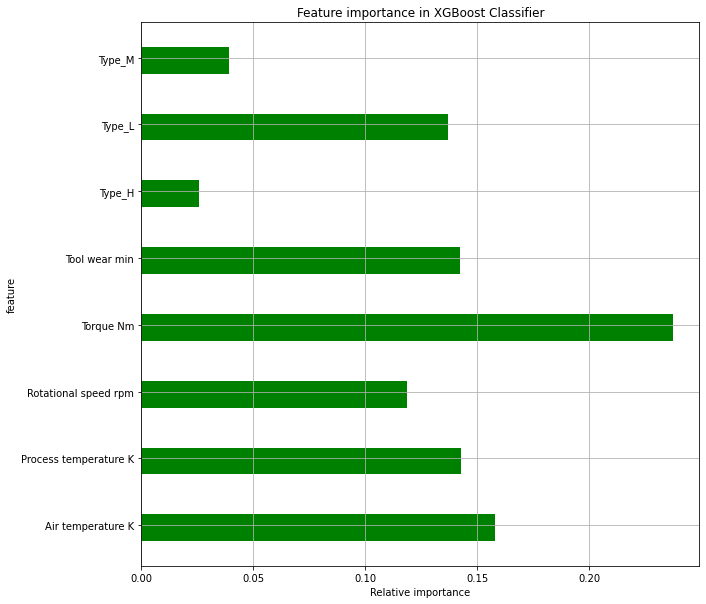

<Figure size 720x720 with 0 Axes>

In [64]:
#modelname.feature_importance_
y = best_random.feature_importances_

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(data_train, minor=False)
plt.title('Feature importance in XGBoost Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.grid()
plt.figure(figsize=(10,10))
fig.set_size_inches(10, 10, forward=True)

In [65]:
from skopt import BayesSearchCV
bayes_grid = {
    "learning_rate": Real(0.01, 1.0, "log-uniform"),
    "min_child_weight": Integer(0, 10),
    "max_depth": Integer(1, 50),
    "max_delta_step": Integer(0, 10),
    "subsample": Real(0.01, 1.0, "uniform"),
    "colsample_bytree": Real(0.01, 1.0, "log-uniform"),
    "colsample_bylevel": Real(0.01, 1.0, "log-uniform"),
    "reg_lambda": Real(1e-9, 1000, "log-uniform"),
    "reg_alpha": Real(1e-9, 1.0, "log-uniform"),
    "gamma": Real(1e-9, 0.5, "log-uniform"),
    "min_child_weight": Integer(0, 5),
    "n_estimators": Integer(5, 500),
}
xgb = XGBClassifier()
#define a stratified cross validation, as our data is highly imbalanced
cv_stratified = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
xgb_bayes = BayesSearchCV(xgb,search_spaces=bayes_grid, cv=cv_stratified, scoring ='f1_macro', refit = True,n_iter=75, random_state = 42,verbose=2)
xgb_bayes.fit(data_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:12:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.06610098295419149, colsample_bytree=0.28539836866041823, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=7, max_depth=21, min_child_weight=2, n_estimators=371, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544643023916863; total time=   1.4s
[17:12:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.06610098295419149, colsample_bytree=0.28539836866041823, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=7, max_depth=21, min_child_weight=2, n_estimators=371, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544643023916863; total time=   1.3s
[17:12:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.06610098295419149, colsample_bytree=0.28539836866041823, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=7, max_depth=21, min_child_weight=2, n_estimators=371, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544643023916863; total time=   1.5s
[17:12:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.06610098295419149, colsample_bytree=0.28539836866041823, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=7, max_depth=21, min_child_weight=2, n_estimators=371, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544643023916863; total time=   1.4s
[17:12:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.06610098295419149, colsample_bytree=0.28539836866041823, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=7, max_depth=21, min_child_weight=2, n_estimators=371, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, subsample=0.5544643023916863; total time=   1.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:12:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4729080547055919, colsample_bytree=0.5842928269761146, gamma=4.358684608480795e-07, learning_rate=0.7988179462781242, max_delta_step=9, max_depth=4, min_child_weight=1, n_estimators=180, reg_alpha=0.0005266983003701547, reg_lambda=276.5424475574225, subsample=0.6336020558163782; total time=   0.5s
[17:13:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4729080547055919, colsample_bytree=0.5842928269761146, gamma=4.358684608480795e-07, learning_rate=0.7988179462781242, max_delta_step=9, max_depth=4, min_child_weight=1, n_estimators=180, reg_alpha=0.0005266983003701547, reg_lambda=276.5424475574225, subsample=0.6336020558163782; total time=   0.5s
[17:13:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4729080547055919, colsample_bytree=0.5842928269761146, gamma=4.358684608480795e-07, learning_rate=0.7988179462781242, max_delta_step=9, max_depth=4, min_child_weight=1, n_estimators=180, reg_alpha=0.0005266983003701547, reg_lambda=276.5424475574225, subsample=0.6336020558163782; total time=   0.5s
[17:13:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4729080547055919, colsample_bytree=0.5842928269761146, gamma=4.358684608480795e-07, learning_rate=0.7988179462781242, max_delta_step=9, max_depth=4, min_child_weight=1, n_estimators=180, reg_alpha=0.0005266983003701547, reg_lambda=276.5424475574225, subsample=0.6336020558163782; total time=   0.5s
[17:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4729080547055919, colsample_bytree=0.5842928269761146, gamma=4.358684608480795e-07, learning_rate=0.7988179462781242, max_delta_step=9, max_depth=4, min_child_weight=1, n_estimators=180, reg_alpha=0.0005266983003701547, reg_lambda=276.5424475574225, subsample=0.6336020558163782; total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07756486208064789, colsample_bytree=0.6877728743793542, gamma=8.168958221061441e-09, learning_rate=0.07356404539935663, max_delta_step=2, max_depth=23, min_child_weight=1, n_estimators=377, reg_alpha=0.00010376808625045426, reg_lambda=476.96194787286544, subsample=0.7064328557952411; total time=   1.0s
[17:13:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07756486208064789, colsample_bytree=0.6877728743793542, gamma=8.168958221061441e-09, learning_rate=0.07356404539935663, max_delta_step=2, max_depth=23, min_child_weight=1, n_estimators=377, reg_alpha=0.00010376808625045426, reg_lambda=476.96194787286544, subsample=0.7064328557952411; total time=   1.2s
[17:13:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07756486208064789, colsample_bytree=0.6877728743793542, gamma=8.168958221061441e-09, learning_rate=0.07356404539935663, max_delta_step=2, max_depth=23, min_child_weight=1, n_estimators=377, reg_alpha=0.00010376808625045426, reg_lambda=476.96194787286544, subsample=0.7064328557952411; total time=   1.4s
[17:13:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07756486208064789, colsample_bytree=0.6877728743793542, gamma=8.168958221061441e-09, learning_rate=0.07356404539935663, max_delta_step=2, max_depth=23, min_child_weight=1, n_estimators=377, reg_alpha=0.00010376808625045426, reg_lambda=476.96194787286544, subsample=0.7064328557952411; total time=   1.6s
[17:13:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07756486208064789, colsample_bytree=0.6877728743793542, gamma=8.168958221061441e-09, learning_rate=0.07356404539935663, max_delta_step=2, max_depth=23, min_child_weight=1, n_estimators=377, reg_alpha=0.00010376808625045426, reg_lambda=476.96194787286544, subsample=0.7064328557952411; total time=   1.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:13:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.42149456283334996, colsample_bytree=0.022066991249460103, gamma=0.00015936523535755285, learning_rate=0.4032083917998946, max_delta_step=5, max_depth=6, min_child_weight=4, n_estimators=437, reg_alpha=0.1611980387486336, reg_lambda=4.3806965488564525e-05, subsample=0.34817978468161015; total time=   1.8s
[17:13:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.42149456283334996, colsample_bytree=0.022066991249460103, gamma=0.00015936523535755285, learning_rate=0.4032083917998946, max_delta_step=5, max_depth=6, min_child_weight=4, n_estimators=437, reg_alpha=0.1611980387486336, reg_lambda=4.3806965488564525e-05, subsample=0.34817978468161015; total time=   1.7s
[17:13:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.42149456283334996, colsample_bytree=0.022066991249460103, gamma=0.00015936523535755285, learning_rate=0.4032083917998946, max_delta_step=5, max_depth=6, min_child_weight=4, n_estimators=437, reg_alpha=0.1611980387486336, reg_lambda=4.3806965488564525e-05, subsample=0.34817978468161015; total time=   1.6s
[17:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.42149456283334996, colsample_bytree=0.022066991249460103, gamma=0.00015936523535755285, learning_rate=0.4032083917998946, max_delta_step=5, max_depth=6, min_child_weight=4, n_estimators=437, reg_alpha=0.1611980387486336, reg_lambda=4.3806965488564525e-05, subsample=0.34817978468161015; total time=   1.6s
[17:13:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.42149456283334996, colsample_bytree=0.022066991249460103, gamma=0.00015936523535755285, learning_rate=0.4032083917998946, max_delta_step=5, max_depth=6, min_child_weight=4, n_estimators=437, reg_alpha=0.1611980387486336, reg_lambda=4.3806965488564525e-05, subsample=0.34817978468161015; total time=   1.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.3972893133963027, colsample_bytree=0.07517239253342656, gamma=3.811128976537413e-05, learning_rate=0.2700390206185342, max_delta_step=9, max_depth=36, min_child_weight=2, n_estimators=327, reg_alpha=1.5057560255472018e-06, reg_lambda=0.08186810622382998, subsample=0.5178580699961443; total time=   1.5s
[17:13:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.3972893133963027, colsample_bytree=0.07517239253342656, gamma=3.811128976537413e-05, learning_rate=0.2700390206185342, max_delta_step=9, max_depth=36, min_child_weight=2, n_estimators=327, reg_alpha=1.5057560255472018e-06, reg_lambda=0.08186810622382998, subsample=0.5178580699961443; total time=   1.7s
[17:13:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.3972893133963027, colsample_bytree=0.07517239253342656, gamma=3.811128976537413e-05, learning_rate=0.2700390206185342, max_delta_step=9, max_depth=36, min_child_weight=2, n_estimators=327, reg_alpha=1.5057560255472018e-06, reg_lambda=0.08186810622382998, subsample=0.5178580699961443; total time=   1.5s
[17:13:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.3972893133963027, colsample_bytree=0.07517239253342656, gamma=3.811128976537413e-05, learning_rate=0.2700390206185342, max_delta_step=9, max_depth=36, min_child_weight=2, n_estimators=327, reg_alpha=1.5057560255472018e-06, reg_lambda=0.08186810622382998, subsample=0.5178580699961443; total time=   1.8s
[17:13:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.3972893133963027, colsample_bytree=0.07517239253342656, gamma=3.811128976537413e-05, learning_rate=0.2700390206185342, max_delta_step=9, max_depth=36, min_child_weight=2, n_estimators=327, reg_alpha=1.5057560255472018e-06, reg_lambda=0.08186810622382998, subsample=0.5178580699961443; total time=   1.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.29380287142759304, colsample_bytree=0.7563790218678241, gamma=2.6498051478267012e-08, learning_rate=0.0238149998729586, max_delta_step=8, max_depth=19, min_child_weight=2, n_estimators=270, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336, subsample=0.5930070264428381; total time=   1.7s
[17:13:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.29380287142759304, colsample_bytree=0.7563790218678241, gamma=2.6498051478267012e-08, learning_rate=0.0238149998729586, max_delta_step=8, max_depth=19, min_child_weight=2, n_estimators=270, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336, subsample=0.5930070264428381; total time=   1.4s
[17:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.29380287142759304, colsample_bytree=0.7563790218678241, gamma=2.6498051478267012e-08, learning_rate=0.0238149998729586, max_delta_step=8, max_depth=19, min_child_weight=2, n_estimators=270, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336, subsample=0.5930070264428381; total time=   1.2s
[17:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.29380287142759304, colsample_bytree=0.7563790218678241, gamma=2.6498051478267012e-08, learning_rate=0.0238149998729586, max_delta_step=8, max_depth=19, min_child_weight=2, n_estimators=270, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336, subsample=0.5930070264428381; total time=   1.5s
[17:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.29380287142759304, colsample_bytree=0.7563790218678241, gamma=2.6498051478267012e-08, learning_rate=0.0238149998729586, max_delta_step=8, max_depth=19, min_child_weight=2, n_estimators=270, reg_alpha=0.011683028450342707, reg_lambda=0.0048879464985534336, subsample=0.5930070264428381; total time=   1.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1714583803805369, colsample_bytree=0.35540927532494104, gamma=1.3277909848852635e-06, learning_rate=0.5605967693796124, max_delta_step=6, max_depth=30, min_child_weight=3, n_estimators=214, reg_alpha=0.004026635957416632, reg_lambda=0.040887904512512056, subsample=0.9250385544668723; total time=   0.9s
[17:13:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1714583803805369, colsample_bytree=0.35540927532494104, gamma=1.3277909848852635e-06, learning_rate=0.5605967693796124, max_delta_step=6, max_depth=30, min_child_weight=3, n_estimators=214, reg_alpha=0.004026635957416632, reg_lambda=0.040887904512512056, subsample=0.9250385544668723; total time=   0.9s
[17:13:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1714583803805369, colsample_bytree=0.35540927532494104, gamma=1.3277909848852635e-06, learning_rate=0.5605967693796124, max_delta_step=6, max_depth=30, min_child_weight=3, n_estimators=214, reg_alpha=0.004026635957416632, reg_lambda=0.040887904512512056, subsample=0.9250385544668723; total time=   0.9s
[17:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1714583803805369, colsample_bytree=0.35540927532494104, gamma=1.3277909848852635e-06, learning_rate=0.5605967693796124, max_delta_step=6, max_depth=30, min_child_weight=3, n_estimators=214, reg_alpha=0.004026635957416632, reg_lambda=0.040887904512512056, subsample=0.9250385544668723; total time=   0.7s
[17:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1714583803805369, colsample_bytree=0.35540927532494104, gamma=1.3277909848852635e-06, learning_rate=0.5605967693796124, max_delta_step=6, max_depth=30, min_child_weight=3, n_estimators=214, reg_alpha=0.004026635957416632, reg_lambda=0.040887904512512056, subsample=0.9250385544668723; total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.12212543829922852, colsample_bytree=0.6918603669668356, gamma=2.083286323303108e-05, learning_rate=0.4734922490673386, max_delta_step=3, max_depth=4, min_child_weight=3, n_estimators=18, reg_alpha=2.9618722230360503e-06, reg_lambda=8.153638964242, subsample=0.373772806

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[17:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.12212543829922852, colsample_bytree=0.6918603669668356, gamma=2.083286323303108e-05, learning_rate=0.4734922490673386, max_delta_step=3, max_depth=4, min_child_weight=3, n_estimators=18, reg_alpha=2.9618722230360503e-06, reg_lambda=8.153638964242, subsample=0.37377280619679043; total time=   0.0s
[17:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.12212543829922852, colsa

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[17:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.12212543829922852, colsample_bytree=0.6918603669668356, gamma=2.083286323303108e-05, learning_rate=0.4734922490673386, max_delta_step=3, max_depth=4, min_child_weight=3, n_estimators=18, reg_alpha=2.9618722230360503e-06, reg_lambda=8.153638964242, subsample=0.37377280619679043; total time=   0.0s
[17:13:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.12212543829922852, colsa

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:13:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.8146216961026963, colsample_bytree=0.2519085390684862, gamma=0.03823613443879595, learning_rate=0.06786442521779147, max_delta_step=4, max_depth=11, min_child_weight=0, n_estimators=188, reg_alpha=0.00022356829889037284, reg_lambda=1.2908532337409298e-07, subsample=0.7697045536001489; total time=   1.3s
[17:13:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.8146216961026963, colsample_bytree=0.2519085390684862, gamma=0.03823613443879595, learning_rate=0.06786442521779147, max_delta_step=4, max_depth=11, min_child_weight=0, n_estimators=188, reg_alpha=0.00022356829889037284, reg_lambda=1.2908532337409298e-07, subsample=0.7697045536001489; total time=   1.1s
[17:13:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.8146216961026963, colsample_bytree=0.2519085390684862, gamma=0.03823613443879595, learning_rate=0.06786442521779147, max_delta_step=4, max_depth=11, min_child_weight=0, n_estimators=188, reg_alpha=0.00022356829889037284, reg_lambda=1.2908532337409298e-07, subsample=0.7697045536001489; total time=   1.1s
[17:13:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.8146216961026963, colsample_bytree=0.2519085390684862, gamma=0.03823613443879595, learning_rate=0.06786442521779147, max_delta_step=4, max_depth=11, min_child_weight=0, n_estimators=188, reg_alpha=0.00022356829889037284, reg_lambda=1.2908532337409298e-07, subsample=0.7697045536001489; total time=   1.0s
[17:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.8146216961026963, colsample_bytree=0.2519085390684862, gamma=0.03823613443879595, learning_rate=0.06786442521779147, max_delta_step=4, max_depth=11, min_child_weight=0, n_estimators=188, reg_alpha=0.00022356829889037284, reg_lambda=1.2908532337409298e-07, subsample=0.7697045536001489; total time=   1.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.010168587136004645, colsample_bytree=0.43217539671382244, gamma=0.002807995180059625, learning_rate=0.03229300915669146, max_delta_step=6, max_depth=14, min_child_weight=2, n_estimators=81, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526; total time=   0.1s
[17:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.010168587136004645, colsample_bytree=0.43217539671382244, gamma=0.002807995180059625, learning_rate=0.03229300915669146, max_delta_step=6, max_depth=14, min_child_weight=2, n_estimators=81, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526; total time=   0.1s


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[17:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.010168587136004645, colsample_bytree=0.43217539671382244, gamma=0.002807995180059625, learning_rate=0.03229300915669146, max_delta_step=6, max_depth=14, min_child_weight=2, n_estimators=81, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526; total time=   0.1s
[17:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index

[CV] END colsample_bylevel=0.010168587136004645, colsample_bytree=0.43217539671382244, gamma=0.002807995180059625, learning_rate=0.03229300915669146, max_delta_step=6, max_depth=14, min_child_weight=2, n_estimators=81, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526; total time=   0.1s
[17:13:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.010168587136004645, colsample_bytree=0.43217539671382244, gamma=0.002807995180059625, learning_rate=0.03229300915669146, max_delta_step=6, max_depth=14, min_child_weight=2, n_estimators=81, reg_alpha=0.11080071157037095, reg_lambda=5.745523087821567, subsample=0.7557881303057526; total time=   0.1s
Fitting 5 folds for each of 1 ca

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.05761776475417049, colsample_bytree=0.17904959052713487, gamma=0.16335732925296614, learning_rate=0.025315720252926537, max_delta_step=7, max_depth=38, min_child_weight=5, n_estimators=264, reg_alpha=8.391042471990939e-06, reg_lambda=0.022779113428291375, subsample=0.6994192556366632; total time=   1.0s
[17:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.05761776475417049, colsample_bytree=0.17904959052713487, gamma=0.16335732925296614, learning_rate=0.025315720252926537, max_delta_step=7, max_depth=38, min_child_weight=5, n_estimators=264, reg_alpha=8.391042471990939e-06, reg_lambda=0.022779113428291375, subsample=0.6994192556366632; total time=   0.8s
[17:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.05761776475417049, colsample_bytree=0.17904959052713487, gamma=0.16335732925296614, learning_rate=0.025315720252926537, max_delta_step=7, max_depth=38, min_child_weight=5, n_estimators=264, reg_alpha=8.391042471990939e-06, reg_lambda=0.022779113428291375, subsample=0.6994192556366632; total time=   0.8s
[17:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.05761776475417049, colsample_bytree=0.17904959052713487, gamma=0.16335732925296614, learning_rate=0.025315720252926537, max_delta_step=7, max_depth=38, min_child_weight=5, n_estimators=264, reg_alpha=8.391042471990939e-06, reg_lambda=0.022779113428291375, subsample=0.6994192556366632; total time=   0.9s
[17:13:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.05761776475417049, colsample_bytree=0.17904959052713487, gamma=0.16335732925296614, learning_rate=0.025315720252926537, max_delta_step=7, max_depth=38, min_child_weight=5, n_estimators=264, reg_alpha=8.391042471990939e-06, reg_lambda=0.022779113428291375, subsample=0.6994192556366632; total time=   1.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:14:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.34237854112106486, colsample_bytree=0.8379514773793961, gamma=5.876655115970051e-08, learning_rate=0.017435102024417528, max_delta_step=2, max_depth=40, min_child_weight=3, n_estimators=428, reg_alpha=2.9069906808872954e-07, reg_lambda=0.01838018407014344, subsample=0.41785209260950734; total time=   1.8s
[17:14:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.34237854112106486, colsample_bytree=0.8379514773793961, gamma=5.876655115970051e-08, learning_rate=0.017435102024417528, max_delta_step=2, max_depth=40, min_child_weight=3, n_estimators=428, reg_alpha=2.9069906808872954e-07, reg_lambda=0.01838018407014344, subsample=0.41785209260950734; total time=   2.2s
[17:14:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.34237854112106486, colsample_bytree=0.8379514773793961, gamma=5.876655115970051e-08, learning_rate=0.017435102024417528, max_delta_step=2, max_depth=40, min_child_weight=3, n_estimators=428, reg_alpha=2.9069906808872954e-07, reg_lambda=0.01838018407014344, subsample=0.41785209260950734; total time=   2.4s
[17:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.34237854112106486, colsample_bytree=0.8379514773793961, gamma=5.876655115970051e-08, learning_rate=0.017435102024417528, max_delta_step=2, max_depth=40, min_child_weight=3, n_estimators=428, reg_alpha=2.9069906808872954e-07, reg_lambda=0.01838018407014344, subsample=0.41785209260950734; total time=   2.3s
[17:14:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.34237854112106486, colsample_bytree=0.8379514773793961, gamma=5.876655115970051e-08, learning_rate=0.017435102024417528, max_delta_step=2, max_depth=40, min_child_weight=3, n_estimators=428, reg_alpha=2.9069906808872954e-07, reg_lambda=0.01838018407014344, subsample=0.41785209260950734; total time=   2.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:14:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.21305610384658882, colsample_bytree=0.16638318784484543, gamma=0.00634775453454405, learning_rate=0.2970418350674322, max_delta_step=9, max_depth=47, min_child_weight=3, n_estimators=286, reg_alpha=0.0003589974811290224, reg_lambda=0.009870122633089489, subsample=0.035438494699388326; total time=   0.6s
[17:14:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.21305610384658882, colsample_bytree=0.16638318784484543, gamma=0.00634775453454405, learning_rate=0.2970418350674322, max_delta_step=9, max_depth=47, min_child_weight=3, n_estimators=286, reg_alpha=0.0003589974811290224, reg_lambda=0.009870122633089489, subsample=0.035438494699388326; total time=   0.4s
[17:14:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.21305610384658882, colsample_bytree=0.16638318784484543, gamma=0.00634775453454405, learning_rate=0.2970418350674322, max_delta_step=9, max_depth=47, min_child_weight=3, n_estimators=286, reg_alpha=0.0003589974811290224, reg_lambda=0.009870122633089489, subsample=0.035438494699388326; total time=   0.4s
[17:14:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.21305610384658882, colsample_bytree=0.16638318784484543, gamma=0.00634775453454405, learning_rate=0.2970418350674322, max_delta_step=9, max_depth=47, min_child_weight=3, n_estimators=286, reg_alpha=0.0003589974811290224, reg_lambda=0.009870122633089489, subsample=0.035438494699388326; total time=   0.4s
[17:14:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.21305610384658882, colsample_bytree=0.16638318784484543, gamma=0.00634775453454405, learning_rate=0.2970418350674322, max_delta_step=9, max_depth=47, min_child_weight=3, n_estimators=286, reg_alpha=0.0003589974811290224, reg_lambda=0.009870122633089489, subsample=0.035438494699388326; total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:14:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.02231643146244539, colsample_bytree=0.6183261967472166, gamma=0.24558625278431873, learning_rate=1.0, max_delta_step=9, max_depth=23, min_child_weight=0, n_estimators=336, reg_alpha=0.00025998774110927604, reg_lambda=1e-09, subsample=1.0; total time=   1.2s
[17:14:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.02231643146244539, colsample_bytree=0.6183261967472166, gamma=0.24558625278431873, learning_rate=1.0, max_delta_step=9, max_depth=23, min_child_weight=0, n_estimators=336, reg_alpha=0.00025998774110927604, reg_lambda=1e-09, subsample=1.0; total time=   1.2s
[17:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.02231643146244539, colsample_bytree=0.6183261967472166, gamma=0.24558625278431873, learning_rate=1.0, max_delta_step=9, max_depth=23, min_child_weight=0, n_estimators=336, reg_alpha=0.00025998774110927604, reg_lambda=1e-09, subsample=1.0; total time=   1.3s
[17:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.02231643146244539, colsample_bytree=0.6183261967472166, gamma=0.24558625278431873, learning_rate=1.0, max_delta_step=9, max_depth=23, min_child_weight=0, n_estimators=336, reg_alpha=0.00025998774110927604, reg_lambda=1e-09, subsample=1.0; total time=   1.2s
[17:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.02231643146244539, colsample_bytree=0.6183261967472166, gamma=0.24558625278431873, learning_rate=1.0, max_delta_step=9, max_depth=23, min_child_weight=0, n_estimators=336, reg_alpha=0.00025998774110927604, reg_lambda=1e-09, subsample=1.0; total time=   1.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:14:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.12949403370337514, colsample_bytree=0.5038433555644545, gamma=3.418816202877858e-06, learning_rate=0.08023391135486613, max_delta_step=1, max_depth=10, min_child_weight=0, n_estimators=430, reg_alpha=3.8132747752584e-09, reg_lambda=0.02429942142249761, subsample=0.37458861032284513; total time=   1.4s
[17:14:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.12949403370337514, colsample_bytree=0.5038433555644545, gamma=3.418816202877858e-06, learning_rate=0.08023391135486613, max_delta_step=1, max_depth=10, min_child_weight=0, n_estimators=430, reg_alpha=3.8132747752584e-09, reg_lambda=0.02429942142249761, subsample=0.37458861032284513; total time=   2.0s
[17:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.12949403370337514, colsample_bytree=0.5038433555644545, gamma=3.418816202877858e-06, learning_rate=0.08023391135486613, max_delta_step=1, max_depth=10, min_child_weight=0, n_estimators=430, reg_alpha=3.8132747752584e-09, reg_lambda=0.02429942142249761, subsample=0.37458861032284513; total time=   2.0s
[17:14:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.12949403370337514, colsample_bytree=0.5038433555644545, gamma=3.418816202877858e-06, learning_rate=0.08023391135486613, max_delta_step=1, max_depth=10, min_child_weight=0, n_estimators=430, reg_alpha=3.8132747752584e-09, reg_lambda=0.02429942142249761, subsample=0.37458861032284513; total time=   1.9s
[17:14:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.12949403370337514, colsample_bytree=0.5038433555644545, gamma=3.418816202877858e-06, learning_rate=0.08023391135486613, max_delta_step=1, max_depth=10, min_child_weight=0, n_estimators=430, reg_alpha=3.8132747752584e-09, reg_lambda=0.02429942142249761, subsample=0.37458861032284513; total time=   1.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.011850748511642735, colsample_bytree=0.527261907713083, gamma=0.0007826650603236946, learning_rate=0.11368315330927835, max_delta_step=6, max_depth=7, min_child_weight=0, n_estimators=224, reg_alpha=1.7033453294727142e-08, reg_lambda=0.05151461967224869, subsample=0.7000815397209816; total time=   0.7s
[17:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.011850748511642735, colsample_bytree=0.527261907713083, gamma=0.0007826650603236946, learning_rate=0.11368315330927835, max_delta_step=6, max_depth=7, min_child_weight=0, n_estimators=224, reg_alpha=1.7033453294727142e-08, reg_lambda=0.05151461967224869, subsample=0.7000815397209816; total time=   0.6s
[17:14:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.011850748511642735, colsample_bytree=0.527261907713083, gamma=0.0007826650603236946, learning_rate=0.11368315330927835, max_delta_step=6, max_depth=7, min_child_weight=0, n_estimators=224, reg_alpha=1.7033453294727142e-08, reg_lambda=0.05151461967224869, subsample=0.7000815397209816; total time=   0.6s
[17:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.011850748511642735, colsample_bytree=0.527261907713083, gamma=0.0007826650603236946, learning_rate=0.11368315330927835, max_delta_step=6, max_depth=7, min_child_weight=0, n_estimators=224, reg_alpha=1.7033453294727142e-08, reg_lambda=0.05151461967224869, subsample=0.7000815397209816; total time=   0.6s
[17:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.011850748511642735, colsample_bytree=0.527261907713083, gamma=0.0007826650603236946, learning_rate=0.11368315330927835, max_delta_step=6, max_depth=7, min_child_weight=0, n_estimators=224, reg_alpha=1.7033453294727142e-08, reg_lambda=0.05151461967224869, subsample=0.7000815397209816; total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:14:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4136323742360416, colsample_bytree=0.4589856996587135, gamma=5.501085834984974e-09, learning_rate=0.6684669698263889, max_delta_step=4, max_depth=10, min_child_weight=3, n_estimators=365, reg_alpha=9.259273652786634e-07, reg_lambda=0.05530857021105358, subsample=0.6644063027799678; total time=   0.8s
[17:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4136323742360416, colsample_bytree=0.4589856996587135, gamma=5.501085834984974e-09, learning_rate=0.6684669698263889, max_delta_step=4, max_depth=10, min_child_weight=3, n_estimators=365, reg_alpha=9.259273652786634e-07, reg_lambda=0.05530857021105358, subsample=0.6644063027799678; total time=   0.9s
[17:14:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4136323742360416, colsample_bytree=0.4589856996587135, gamma=5.501085834984974e-09, learning_rate=0.6684669698263889, max_delta_step=4, max_depth=10, min_child_weight=3, n_estimators=365, reg_alpha=9.259273652786634e-07, reg_lambda=0.05530857021105358, subsample=0.6644063027799678; total time=   0.9s
[17:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4136323742360416, colsample_bytree=0.4589856996587135, gamma=5.501085834984974e-09, learning_rate=0.6684669698263889, max_delta_step=4, max_depth=10, min_child_weight=3, n_estimators=365, reg_alpha=9.259273652786634e-07, reg_lambda=0.05530857021105358, subsample=0.6644063027799678; total time=   1.2s
[17:14:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.4136323742360416, colsample_bytree=0.4589856996587135, gamma=5.501085834984974e-09, learning_rate=0.6684669698263889, max_delta_step=4, max_depth=10, min_child_weight=3, n_estimators=365, reg_alpha=9.259273652786634e-07, reg_lambda=0.05530857021105358, subsample=0.6644063027799678; total time=   1.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.36059947846553875, colsample_bytree=0.5572350779468459, gamma=0.0001499226040623716, learning_rate=0.02012115992316059, max_delta_step=2, max_depth=28, min_child_weight=3, n_estimators=93, reg_alpha=0.00010992476397619665, reg_lambda=0.07433601270662317, subsample=0.9825510387566594; total time=   0.3s
[17:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.36059947846553875, colsample_bytree=0.5572350779468459, gamma=0.0001499226040623716, learning_rate=0.02012115992316059, max_delta_step=2, max_depth=28, min_child_weight=3, n_estimators=93, reg_alpha=0.00010992476397619665, reg_lambda=0.07433601270662317, subsample=0.9825510387566594; total time=   0.2s
[17:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.36059947846553875, colsample_bytree=0.5572350779468459, gamma=0.0001499226040623716, learning_rate=0.02012115992316059, max_delta_step=2, max_depth=28, min_child_weight=3, n_estimators=93, reg_alpha=0.00010992476397619665, reg_lambda=0.07433601270662317, subsample=0.9825510387566594; total time=   0.2s
[17:15:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.36059947846553875, colsample_bytree=0.5572350779468459, gamma=0.0001499226040623716, learning_rate=0.02012115992316059, max_delta_step=2, max_depth=28, min_child_weight=3, n_estimators=93, reg_alpha=0.00010992476397619665, reg_lambda=0.07433601270662317, subsample=0.9825510387566594; total time=   0.2s
[17:15:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.36059947846553875, colsample_bytree=0.5572350779468459, gamma=0.0001499226040623716, learning_rate=0.02012115992316059, max_delta_step=2, max_depth=28, min_child_weight=3, n_estimators=93, reg_alpha=0.00010992476397619665, reg_lambda=0.07433601270662317, subsample=0.9825510387566594; total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.49799910980205647, gamma=1e-09, learning_rate=1.0, max_delta_step=2, max_depth=1, min_child_weight=4, n_estimators=500, reg_alpha=2.6454457412234097e-07, reg_lambda=1.9431220371095362e-05, subsample=1.0; total time=   0.6s
[17:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.49799910980205647, gamma=1e-09, learning_rate=1.0, max_delta_step=2, max_depth=1, min_child_weight=4, n_estimators=500, reg_alpha=2.6454457412234097e-07, reg_lambda=1.9431220371095362e-05, subsample=1.0; total time=   0.6s
[17:15:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.49799910980205647, gamma=1e-09, learning_rate=1.0, max_delta_step=2, max_depth=1, min_child_weight=4, n_estimators=500, reg_alpha=2.6454457412234097e-07, reg_lambda=1.9431220371095362e-05, subsample=1.0; total time=   0.7s
[17:15:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.49799910980205647, gamma=1e-09, learning_rate=1.0, max_delta_step=2, max_depth=1, min_child_weight=4, n_estimators=500, reg_alpha=2.6454457412234097e-07, reg_lambda=1.9431220371095362e-05, subsample=1.0; total time=   0.9s
[17:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.49799910980205647, gamma=1e-09, learning_rate=1.0, max_delta_step=2, max_depth=1, min_child_weight=4, n_estimators=500, reg_alpha=2.6454457412234097e-07, reg_lambda=1.9431220371095362e-05, subsample=1.0; total time=   1.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:15:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.5124655942615212, colsample_bytree=0.3115552246142577, gamma=1e-09, learning_rate=1.0, max_delta_step=3, max_depth=16, min_child_weight=1, n_estimators=500, reg_alpha=4.401941934730409e-07, reg_lambda=1.0171550756764816, subsample=1.0; total time=   0.9s
[17:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.5124655942615212, colsample_bytree=0.3115552246142577, gamma=1e-09, learning_rate=1.0, max_delta_step=3, max_depth=16, min_child_weight=1, n_estimators=500, reg_alpha=4.401941934730409e-07, reg_lambda=1.0171550756764816, subsample=1.0; total time=   0.8s
[17:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.5124655942615212, colsample_bytree=0.3115552246142577, gamma=1e-09, learning_rate=1.0, max_delta_step=3, max_depth=16, min_child_weight=1, n_estimators=500, reg_alpha=4.401941934730409e-07, reg_lambda=1.0171550756764816, subsample=1.0; total time=   0.8s
[17:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.5124655942615212, colsample_bytree=0.3115552246142577, gamma=1e-09, learning_rate=1.0, max_delta_step=3, max_depth=16, min_child_weight=1, n_estimators=500, reg_alpha=4.401941934730409e-07, reg_lambda=1.0171550756764816, subsample=1.0; total time=   0.8s
[17:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.5124655942615212, colsample_bytree=0.3115552246142577, gamma=1e-09, learning_rate=1.0, max_delta_step=3, max_depth=16, min_child_weight=1, n_estimators=500, reg_alpha=4.401941934730409e-07, reg_lambda=1.0171550756764816, subsample=1.0; total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1549237802373501, colsample_bytree=0.03810020697869132, gamma=1e-09, learning_rate=0.034249418237519674, max_delta_step=4, max_depth=17, min_child_weight=2, n_estimators=472, reg_alpha=1.131580655428831e-08, reg_lambda=596.5081872126275, subsample=0.9266876917929283; total time=   0.8s
[17:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1549237802373501, colsample_bytree=0.03810020697869132, gamma=1e-09, learning_rate=0.034249418237519674, max_delta_step=4, max_depth=17, min_child_weight=2, n_estimators=472, reg_alpha=1.131580655428831e-08, reg_lambda=596.5081872126275, subsample=0.9266876917929283; total time=   0.8s
[17:15:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1549237802373501, colsample_bytree=0.03810020697869132, gamma=1e-09, learning_rate=0.034249418237519674, max_delta_step=4, max_depth=17, min_child_weight=2, n_estimators=472, reg_alpha=1.131580655428831e-08, reg_lambda=596.5081872126275, subsample=0.9266876917929283; total time=   0.8s
[17:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1549237802373501, colsample_bytree=0.03810020697869132, gamma=1e-09, learning_rate=0.034249418237519674, max_delta_step=4, max_depth=17, min_child_weight=2, n_estimators=472, reg_alpha=1.131580655428831e-08, reg_lambda=596.5081872126275, subsample=0.9266876917929283; total time=   0.8s
[17:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1549237802373501, colsample_bytree=0.03810020697869132, gamma=1e-09, learning_rate=0.034249418237519674, max_delta_step=4, max_depth=17, min_child_weight=2, n_estimators=472, reg_alpha=1.131580655428831e-08, reg_lambda=596.5081872126275, subsample=0.9266876917929283; total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:15:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1912271046193408, colsample_bytree=1.0, gamma=1.5861220739232165e-08, learning_rate=1.0, max_delta_step=9, max_depth=6, min_child_weight=0, n_estimators=418, reg_alpha=1e-09, reg_lambda=0.0003585736496778882, subsample=0.7388299874643077; total time=   1.4s
[17:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1912271046193408, colsample_bytree=1.0, gamma=1.5861220739232165e-08, learning_rate=1.0, max_delta_step=9, max_depth=6, min_child_weight=0, n_estimators=418, reg_alpha=1e-09, reg_lambda=0.0003585736496778882, subsample=0.7388299874643077; total time=   1.5s
[17:15:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1912271046193408, colsample_bytree=1.0, gamma=1.5861220739232165e-08, learning_rate=1.0, max_delta_step=9, max_depth=6, min_child_weight=0, n_estimators=418, reg_alpha=1e-09, reg_lambda=0.0003585736496778882, subsample=0.7388299874643077; total time=   1.7s
[17:15:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1912271046193408, colsample_bytree=1.0, gamma=1.5861220739232165e-08, learning_rate=1.0, max_delta_step=9, max_depth=6, min_child_weight=0, n_estimators=418, reg_alpha=1e-09, reg_lambda=0.0003585736496778882, subsample=0.7388299874643077; total time=   2.7s
[17:15:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1912271046193408, colsample_bytree=1.0, gamma=1.5861220739232165e-08, learning_rate=1.0, max_delta_step=9, max_depth=6, min_child_weight=0, n_estimators=418, reg_alpha=1e-09, reg_lambda=0.0003585736496778882, subsample=0.7388299874643077; total time=   2.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.029931170147882765, colsample_bytree=0.039826409721263833, gamma=5.20077765399371e-09, learning_rate=0.7834708632849618, max_delta_step=3, max_depth=1, min_child_weight=1, n_estimators=209, reg_alpha=5.2935145055789064e-09, reg_lambda=0.010596878780919175, subsample=0.7493453822712787; total time=   0.4s
[17:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.029931170147882765, colsample_bytree=0.039826409721263833, gamma=5.20077765399371e-09, learning_rate=0.7834708632849618, max_delta_step=3, max_depth=1, min_child_weight=1, n_estimators=209, reg_alpha=5.2935145055789064e-09, reg_lambda=0.010596878780919175, subsample=0.7493453822712787; total time=   0.3s
[17:15:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.029931170147882765, colsample_bytree=0.039826409721263833, gamma=5.20077765399371e-09, learning_rate=0.7834708632849618, max_delta_step=3, max_depth=1, min_child_weight=1, n_estimators=209, reg_alpha=5.2935145055789064e-09, reg_lambda=0.010596878780919175, subsample=0.7493453822712787; total time=   0.4s
[17:15:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.029931170147882765, colsample_bytree=0.039826409721263833, gamma=5.20077765399371e-09, learning_rate=0.7834708632849618, max_delta_step=3, max_depth=1, min_child_weight=1, n_estimators=209, reg_alpha=5.2935145055789064e-09, reg_lambda=0.010596878780919175, subsample=0.7493453822712787; total time=   0.4s
[17:15:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.029931170147882765, colsample_bytree=0.039826409721263833, gamma=5.20077765399371e-09, learning_rate=0.7834708632849618, max_delta_step=3, max_depth=1, min_child_weight=1, n_estimators=209, reg_alpha=5.2935145055789064e-09, reg_lambda=0.010596878780919175, subsample=0.7493453822712787; total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:16:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.08814848083812642, colsample_bytree=1.0, gamma=2.4209135108796764e-06, learning_rate=0.2745280484936397, max_delta_step=5, max_depth=11, min_child_weight=0, n_estimators=430, reg_alpha=1e-09, reg_lambda=0.008901096425529215, subsample=0.6806287986099766; total time=   1.9s
[17:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.08814848083812642, colsample_bytree=1.0, gamma=2.4209135108796764e-06, learning_rate=0.2745280484936397, max_delta_step=5, max_depth=11, min_child_weight=0, n_estimators=430, reg_alpha=1e-09, reg_lambda=0.008901096425529215, subsample=0.6806287986099766; total time=   2.3s
[17:16:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.08814848083812642, colsample_bytree=1.0, gamma=2.4209135108796764e-06, learning_rate=0.2745280484936397, max_delta_step=5, max_depth=11, min_child_weight=0, n_estimators=430, reg_alpha=1e-09, reg_lambda=0.008901096425529215, subsample=0.6806287986099766; total time=   2.3s
[17:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.08814848083812642, colsample_bytree=1.0, gamma=2.4209135108796764e-06, learning_rate=0.2745280484936397, max_delta_step=5, max_depth=11, min_child_weight=0, n_estimators=430, reg_alpha=1e-09, reg_lambda=0.008901096425529215, subsample=0.6806287986099766; total time=   2.1s
[17:16:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.08814848083812642, colsample_bytree=1.0, gamma=2.4209135108796764e-06, learning_rate=0.2745280484936397, max_delta_step=5, max_depth=11, min_child_weight=0, n_estimators=430, reg_alpha=1e-09, reg_lambda=0.008901096425529215, subsample=0.6806287986099766; total time=   2.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:16:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07944140728280194, colsample_bytree=1.0, gamma=7.883146110902423e-09, learning_rate=1.0, max_delta_step=2, max_depth=39, min_child_weight=0, n_estimators=442, reg_alpha=0.2857187776984018, reg_lambda=0.009961114540413516, subsample=0.7824359342673484; total time=   1.0s
[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07944140728280194, colsample_bytree=1.0, gamma=7.883146110902423e-09, learning_rate=1.0, max_delta_step=2, max_depth=39, min_child_weight=0, n_estimators=442, reg_alpha=0.2857187776984018, reg_lambda=0.009961114540413516, subsample=0.7824359342673484; total time=   1.2s
[17:16:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07944140728280194, colsample_bytree=1.0, gamma=7.883146110902423e-09, learning_rate=1.0, max_delta_step=2, max_depth=39, min_child_weight=0, n_estimators=442, reg_alpha=0.2857187776984018, reg_lambda=0.009961114540413516, subsample=0.7824359342673484; total time=   1.8s
[17:16:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07944140728280194, colsample_bytree=1.0, gamma=7.883146110902423e-09, learning_rate=1.0, max_delta_step=2, max_depth=39, min_child_weight=0, n_estimators=442, reg_alpha=0.2857187776984018, reg_lambda=0.009961114540413516, subsample=0.7824359342673484; total time=   1.6s
[17:16:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07944140728280194, colsample_bytree=1.0, gamma=7.883146110902423e-09, learning_rate=1.0, max_delta_step=2, max_depth=39, min_child_weight=0, n_estimators=442, reg_alpha=0.2857187776984018, reg_lambda=0.009961114540413516, subsample=0.7824359342673484; total time=   1.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:16:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.017386152378618954, colsample_bytree=1.0, gamma=4.4564966863835286e-07, learning_rate=0.01, max_delta_step=6, max_depth=27, min_child_weight=0, n_estimators=325, reg_alpha=7.2668582499437725e-09, reg_lambda=1.6282009303637912e-05, subsample=0.19508515554847505; total time=   1.6s
[17:16:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.017386152378618954, colsample_bytree=1.0, gamma=4.4564966863835286e-07, learning_rate=0.01, max_delta_step=6, max_depth=27, min_child_weight=0, n_estimators=325, reg_alpha=7.2668582499437725e-09, reg_lambda=1.6282009303637912e-05, subsample=0.19508515554847505; total time=   2.3s
[17:16:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.017386152378618954, colsample_bytree=1.0, gamma=4.4564966863835286e-07, learning_rate=0.01, max_delta_step=6, max_depth=27, min_child_weight=0, n_estimators=325, reg_alpha=7.2668582499437725e-09, reg_lambda=1.6282009303637912e-05, subsample=0.19508515554847505; total time=   2.4s
[17:16:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.017386152378618954, colsample_bytree=1.0, gamma=4.4564966863835286e-07, learning_rate=0.01, max_delta_step=6, max_depth=27, min_child_weight=0, n_estimators=325, reg_alpha=7.2668582499437725e-09, reg_lambda=1.6282009303637912e-05, subsample=0.19508515554847505; total time=   1.8s
[17:16:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.017386152378618954, colsample_bytree=1.0, gamma=4.4564966863835286e-07, learning_rate=0.01, max_delta_step=6, max_depth=27, min_child_weight=0, n_estimators=325, reg_alpha=7.2668582499437725e-09, reg_lambda=1.6282009303637912e-05, subsample=0.19508515554847505; total time=   1.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:16:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04168284999492577, colsample_bytree=1.0, gamma=1.1875029796423301e-09, learning_rate=1.0, max_delta_step=10, max_depth=7, min_child_weight=5, n_estimators=478, reg_alpha=6.106974944740066e-07, reg_lambda=1.1367395019236654e-09, subsample=0.6503656872821282; total time=   1.4s
[17:16:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04168284999492577, colsample_bytree=1.0, gamma=1.1875029796423301e-09, learning_rate=1.0, max_delta_step=10, max_depth=7, min_child_weight=5, n_estimators=478, reg_alpha=6.106974944740066e-07, reg_lambda=1.1367395019236654e-09, subsample=0.6503656872821282; total time=   1.6s
[17:16:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04168284999492577, colsample_bytree=1.0, gamma=1.1875029796423301e-09, learning_rate=1.0, max_delta_step=10, max_depth=7, min_child_weight=5, n_estimators=478, reg_alpha=6.106974944740066e-07, reg_lambda=1.1367395019236654e-09, subsample=0.6503656872821282; total time=   1.6s
[17:16:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04168284999492577, colsample_bytree=1.0, gamma=1.1875029796423301e-09, learning_rate=1.0, max_delta_step=10, max_depth=7, min_child_weight=5, n_estimators=478, reg_alpha=6.106974944740066e-07, reg_lambda=1.1367395019236654e-09, subsample=0.6503656872821282; total time=   1.6s
[17:16:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04168284999492577, colsample_bytree=1.0, gamma=1.1875029796423301e-09, learning_rate=1.0, max_delta_step=10, max_depth=7, min_child_weight=5, n_estimators=478, reg_alpha=6.106974944740066e-07, reg_lambda=1.1367395019236654e-09, subsample=0.6503656872821282; total time=   1.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03473454904563838, colsample_bytree=1.0, gamma=0.006696634659621478, learning_rate=0.14298787316090705, max_delta_step=6, max_depth=1, min_child_weight=0, n_estimators=281, reg_alpha=1e-09, reg_lambda=0.004309561028414488, subsample=0.6035511866914878; total time=   0.4s
[17:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03473454904563838, colsample_bytree=1.0, gamma=0.006696634659621478, learning_rate=0.14298787316090705, max_delta_step=6, max_depth=1, min_child_weight=0, n_estimators=281, reg_alpha=1e-09, reg_lambda=0.004309561028414488, subsample=0.6035511866914878; total time=   0.4s
[17:17:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03473454904563838, colsample_bytree=1.0, gamma=0.006696634659621478, learning_rate=0.14298787316090705, max_delta_step=6, max_depth=1, min_child_weight=0, n_estimators=281, reg_alpha=1e-09, reg_lambda=0.004309561028414488, subsample=0.6035511866914878; total time=   0.4s
[17:17:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03473454904563838, colsample_bytree=1.0, gamma=0.006696634659621478, learning_rate=0.14298787316090705, max_delta_step=6, max_depth=1, min_child_weight=0, n_estimators=281, reg_alpha=1e-09, reg_lambda=0.004309561028414488, subsample=0.6035511866914878; total time=   0.4s
[17:17:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03473454904563838, colsample_bytree=1.0, gamma=0.006696634659621478, learning_rate=0.14298787316090705, max_delta_step=6, max_depth=1, min_child_weight=0, n_estimators=281, reg_alpha=1e-09, reg_lambda=0.004309561028414488, subsample=0.6035511866914878; total time=   0.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:17:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04251413441710676, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.1449781287702327, max_delta_step=6, max_depth=13, min_child_weight=0, n_estimators=500, reg_alpha=0.009894969952941503, reg_lambda=0.02550006662567369, subsample=0.8195039136309821; total time=   1.6s
[17:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04251413441710676, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.1449781287702327, max_delta_step=6, max_depth=13, min_child_weight=0, n_estimators=500, reg_alpha=0.009894969952941503, reg_lambda=0.02550006662567369, subsample=0.8195039136309821; total time=   1.5s
[17:17:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04251413441710676, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.1449781287702327, max_delta_step=6, max_depth=13, min_child_weight=0, n_estimators=500, reg_alpha=0.009894969952941503, reg_lambda=0.02550006662567369, subsample=0.8195039136309821; total time=   1.4s
[17:17:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04251413441710676, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.1449781287702327, max_delta_step=6, max_depth=13, min_child_weight=0, n_estimators=500, reg_alpha=0.009894969952941503, reg_lambda=0.02550006662567369, subsample=0.8195039136309821; total time=   1.4s
[17:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.04251413441710676, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.1449781287702327, max_delta_step=6, max_depth=13, min_child_weight=0, n_estimators=500, reg_alpha=0.009894969952941503, reg_lambda=0.02550006662567369, subsample=0.8195039136309821; total time=   1.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:17:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.19663639826669924, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.31508735004657007, max_delta_step=1, max_depth=8, min_child_weight=0, n_estimators=500, reg_alpha=2.312259239287072e-06, reg_lambda=0.024616635029172843, subsample=0.7563592431694465; total time=   1.4s
[17:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.19663639826669924, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.31508735004657007, max_delta_step=1, max_depth=8, min_child_weight=0, n_estimators=500, reg_alpha=2.312259239287072e-06, reg_lambda=0.024616635029172843, subsample=0.7563592431694465; total time=   1.3s
[17:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.19663639826669924, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.31508735004657007, max_delta_step=1, max_depth=8, min_child_weight=0, n_estimators=500, reg_alpha=2.312259239287072e-06, reg_lambda=0.024616635029172843, subsample=0.7563592431694465; total time=   1.3s
[17:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.19663639826669924, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.31508735004657007, max_delta_step=1, max_depth=8, min_child_weight=0, n_estimators=500, reg_alpha=2.312259239287072e-06, reg_lambda=0.024616635029172843, subsample=0.7563592431694465; total time=   1.5s
[17:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.19663639826669924, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.31508735004657007, max_delta_step=1, max_depth=8, min_child_weight=0, n_estimators=500, reg_alpha=2.312259239287072e-06, reg_lambda=0.024616635029172843, subsample=0.7563592431694465; total time=   1.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:17:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03259822111985862, colsample_bytree=1.0, gamma=1.8139103692196432e-07, learning_rate=0.30046431169648674, max_delta_step=7, max_depth=3, min_child_weight=0, n_estimators=351, reg_alpha=1e-09, reg_lambda=0.04365082778689132, subsample=0.8786600277680021; total time=   0.8s
[17:17:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03259822111985862, colsample_bytree=1.0, gamma=1.8139103692196432e-07, learning_rate=0.30046431169648674, max_delta_step=7, max_depth=3, min_child_weight=0, n_estimators=351, reg_alpha=1e-09, reg_lambda=0.04365082778689132, subsample=0.8786600277680021; total time=   0.7s
[17:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03259822111985862, colsample_bytree=1.0, gamma=1.8139103692196432e-07, learning_rate=0.30046431169648674, max_delta_step=7, max_depth=3, min_child_weight=0, n_estimators=351, reg_alpha=1e-09, reg_lambda=0.04365082778689132, subsample=0.8786600277680021; total time=   0.7s
[17:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03259822111985862, colsample_bytree=1.0, gamma=1.8139103692196432e-07, learning_rate=0.30046431169648674, max_delta_step=7, max_depth=3, min_child_weight=0, n_estimators=351, reg_alpha=1e-09, reg_lambda=0.04365082778689132, subsample=0.8786600277680021; total time=   0.7s
[17:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.03259822111985862, colsample_bytree=1.0, gamma=1.8139103692196432e-07, learning_rate=0.30046431169648674, max_delta_step=7, max_depth=3, min_child_weight=0, n_estimators=351, reg_alpha=1e-09, reg_lambda=0.04365082778689132, subsample=0.8786600277680021; total time=   0.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.0181788782074006, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=9, max_depth=24, min_child_weight=3, n_estimators=500, reg_alpha=2.565963262678665e-09, reg_lambda=0.021877400855395912, subsample=0.8103229227306376; total time=   0.9s
[17:17:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.0181788782074006, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=9, max_depth=24, min_child_weight=3, n_estimators=500, reg_alpha=2.565963262678665e-09, reg_lambda=0.021877400855395912, subsample=0.8103229227306376; total time=   0.9s
[17:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.0181788782074006, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=9, max_depth=24, min_child_weight=3, n_estimators=500, reg_alpha=2.565963262678665e-09, reg_lambda=0.021877400855395912, subsample=0.8103229227306376; total time=   0.9s
[17:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.0181788782074006, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=9, max_depth=24, min_child_weight=3, n_estimators=500, reg_alpha=2.565963262678665e-09, reg_lambda=0.021877400855395912, subsample=0.8103229227306376; total time=   1.2s
[17:17:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.0181788782074006, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=9, max_depth=24, min_child_weight=3, n_estimators=500, reg_alpha=2.565963262678665e-09, reg_lambda=0.021877400855395912, subsample=0.8103229227306376; total time=   1.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.666376432236576, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=4, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.10652851387187998, reg_lambda=1e-09, subsample=1.0; total time=   0.9s
[17:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.666376432236576, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=4, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.10652851387187998, reg_lambda=1e-09, subsample=1.0; total time=   0.9s
[17:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.666376432236576, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=4, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.10652851387187998, reg_lambda=1e-09, subsample=1.0; total time=   1.1s
[17:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.666376432236576, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=4, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.10652851387187998, reg_lambda=1e-09, subsample=1.0; total time=   1.3s
[17:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.666376432236576, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=4, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.10652851387187998, reg_lambda=1e-09, subsample=1.0; total time=   1.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1603241484110039, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.11730008158725498, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=2.616751914522431e-05, reg_lambda=0.03232739548816092, subsample=0.6446399963752273; total time=   1.5s
[17:18:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1603241484110039, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.11730008158725498, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=2.616751914522431e-05, reg_lambda=0.03232739548816092, subsample=0.6446399963752273; total time=   1.9s
[17:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1603241484110039, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.11730008158725498, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=2.616751914522431e-05, reg_lambda=0.03232739548816092, subsample=0.6446399963752273; total time=   2.0s
[17:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1603241484110039, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.11730008158725498, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=2.616751914522431e-05, reg_lambda=0.03232739548816092, subsample=0.6446399963752273; total time=   2.1s
[17:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1603241484110039, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.11730008158725498, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=2.616751914522431e-05, reg_lambda=0.03232739548816092, subsample=0.6446399963752273; total time=   2.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07451666334963343, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.3498942573907796, max_delta_step=0, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=3.152360108662844e-07, reg_lambda=0.019846888155798374, subsample=0.7879620231591385; total time=   0.8s
[17:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07451666334963343, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.3498942573907796, max_delta_step=0, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=3.152360108662844e-07, reg_lambda=0.019846888155798374, subsample=0.7879620231591385; total time=   0.9s
[17:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07451666334963343, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.3498942573907796, max_delta_step=0, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=3.152360108662844e-07, reg_lambda=0.019846888155798374, subsample=0.7879620231591385; total time=   1.0s
[17:18:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07451666334963343, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.3498942573907796, max_delta_step=0, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=3.152360108662844e-07, reg_lambda=0.019846888155798374, subsample=0.7879620231591385; total time=   1.0s
[17:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.07451666334963343, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.3498942573907796, max_delta_step=0, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=3.152360108662844e-07, reg_lambda=0.019846888155798374, subsample=0.7879620231591385; total time=   1.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:18:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.10036452448130846, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.20269471016995885, max_delta_step=4, max_depth=6, min_child_weight=0, n_estimators=500, reg_alpha=8.166606788257092e-07, reg_lambda=0.0009735070021419858, subsample=0.7860207973671945; total time=   1.3s
[17:18:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.10036452448130846, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.20269471016995885, max_delta_step=4, max_depth=6, min_child_weight=0, n_estimators=500, reg_alpha=8.166606788257092e-07, reg_lambda=0.0009735070021419858, subsample=0.7860207973671945; total time=   1.3s
[17:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.10036452448130846, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.20269471016995885, max_delta_step=4, max_depth=6, min_child_weight=0, n_estimators=500, reg_alpha=8.166606788257092e-07, reg_lambda=0.0009735070021419858, subsample=0.7860207973671945; total time=   1.4s
[17:18:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.10036452448130846, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.20269471016995885, max_delta_step=4, max_depth=6, min_child_weight=0, n_estimators=500, reg_alpha=8.166606788257092e-07, reg_lambda=0.0009735070021419858, subsample=0.7860207973671945; total time=   1.9s
[17:18:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.10036452448130846, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.20269471016995885, max_delta_step=4, max_depth=6, min_child_weight=0, n_estimators=500, reg_alpha=8.166606788257092e-07, reg_lambda=0.0009735070021419858, subsample=0.7860207973671945; total time=   2.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:18:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01884405933191012, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.2771112448662772, max_delta_step=3, max_depth=13, min_child_weight=1, n_estimators=427, reg_alpha=1.5885572961334674e-09, reg_lambda=0.008732834730271515, subsample=0.7275943783015086; total time=   1.0s
[17:18:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01884405933191012, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.2771112448662772, max_delta_step=3, max_depth=13, min_child_weight=1, n_estimators=427, reg_alpha=1.5885572961334674e-09, reg_lambda=0.008732834730271515, subsample=0.7275943783015086; total time=   1.2s
[17:18:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01884405933191012, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.2771112448662772, max_delta_step=3, max_depth=13, min_child_weight=1, n_estimators=427, reg_alpha=1.5885572961334674e-09, reg_lambda=0.008732834730271515, subsample=0.7275943783015086; total time=   1.4s
[17:18:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01884405933191012, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.2771112448662772, max_delta_step=3, max_depth=13, min_child_weight=1, n_estimators=427, reg_alpha=1.5885572961334674e-09, reg_lambda=0.008732834730271515, subsample=0.7275943783015086; total time=   1.5s
[17:18:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01884405933191012, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.2771112448662772, max_delta_step=3, max_depth=13, min_child_weight=1, n_estimators=427, reg_alpha=1.5885572961334674e-09, reg_lambda=0.008732834730271515, subsample=0.7275943783015086; total time=   1.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:18:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.11613217961232473, colsample_bytree=1.0, gamma=3.6785820362139126e-07, learning_rate=0.17763341927885776, max_delta_step=5, max_depth=17, min_child_weight=0, n_estimators=500, reg_alpha=2.8879062761719e-07, reg_lambda=0.012659260944461792, subsample=0.7676333073495561; total time=   1.5s
[17:19:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.11613217961232473, colsample_bytree=1.0, gamma=3.6785820362139126e-07, learning_rate=0.17763341927885776, max_delta_step=5, max_depth=17, min_child_weight=0, n_estimators=500, reg_alpha=2.8879062761719e-07, reg_lambda=0.012659260944461792, subsample=0.7676333073495561; total time=   2.5s
[17:19:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.11613217961232473, colsample_bytree=1.0, gamma=3.6785820362139126e-07, learning_rate=0.17763341927885776, max_delta_step=5, max_depth=17, min_child_weight=0, n_estimators=500, reg_alpha=2.8879062761719e-07, reg_lambda=0.012659260944461792, subsample=0.7676333073495561; total time=   2.4s
[17:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.11613217961232473, colsample_bytree=1.0, gamma=3.6785820362139126e-07, learning_rate=0.17763341927885776, max_delta_step=5, max_depth=17, min_child_weight=0, n_estimators=500, reg_alpha=2.8879062761719e-07, reg_lambda=0.012659260944461792, subsample=0.7676333073495561; total time=   1.9s
[17:19:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.11613217961232473, colsample_bytree=1.0, gamma=3.6785820362139126e-07, learning_rate=0.17763341927885776, max_delta_step=5, max_depth=17, min_child_weight=0, n_estimators=500, reg_alpha=2.8879062761719e-07, reg_lambda=0.012659260944461792, subsample=0.7676333073495561; total time=   2.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1781374725563356, colsample_bytree=1.0, gamma=6.537439417968456e-06, learning_rate=0.4629700547354594, max_delta_step=10, max_depth=7, min_child_weight=0, n_estimators=423, reg_alpha=1e-09, reg_lambda=0.0047601212017461545, subsample=0.8883849245558945; total time=   1.0s
[17:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1781374725563356, colsample_bytree=1.0, gamma=6.537439417968456e-06, learning_rate=0.4629700547354594, max_delta_step=10, max_depth=7, min_child_weight=0, n_estimators=423, reg_alpha=1e-09, reg_lambda=0.0047601212017461545, subsample=0.8883849245558945; total time=   1.0s
[17:19:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1781374725563356, colsample_bytree=1.0, gamma=6.537439417968456e-06, learning_rate=0.4629700547354594, max_delta_step=10, max_depth=7, min_child_weight=0, n_estimators=423, reg_alpha=1e-09, reg_lambda=0.0047601212017461545, subsample=0.8883849245558945; total time=   1.2s
[17:19:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1781374725563356, colsample_bytree=1.0, gamma=6.537439417968456e-06, learning_rate=0.4629700547354594, max_delta_step=10, max_depth=7, min_child_weight=0, n_estimators=423, reg_alpha=1e-09, reg_lambda=0.0047601212017461545, subsample=0.8883849245558945; total time=   1.4s
[17:19:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.1781374725563356, colsample_bytree=1.0, gamma=6.537439417968456e-06, learning_rate=0.4629700547354594, max_delta_step=10, max_depth=7, min_child_weight=0, n_estimators=423, reg_alpha=1e-09, reg_lambda=0.0047601212017461545, subsample=0.8883849245558945; total time=   1.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:19:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.2584143614352503, colsample_bytree=1.0, gamma=2.4706601467367835e-09, learning_rate=1.0, max_delta_step=5, max_depth=23, min_child_weight=3, n_estimators=361, reg_alpha=4.199747151830086e-08, reg_lambda=0.06563966005458474, subsample=1.0; total time=   0.7s
[17:19:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.2584143614352503, colsample_bytree=1.0, gamma=2.4706601467367835e-09, learning_rate=1.0, max_delta_step=5, max_depth=23, min_child_weight=3, n_estimators=361, reg_alpha=4.199747151830086e-08, reg_lambda=0.06563966005458474, subsample=1.0; total time=   0.6s
[17:19:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.2584143614352503, colsample_bytree=1.0, gamma=2.4706601467367835e-09, learning_rate=1.0, max_delta_step=5, max_depth=23, min_child_weight=3, n_estimators=361, reg_alpha=4.199747151830086e-08, reg_lambda=0.06563966005458474, subsample=1.0; total time=   0.6s
[17:19:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.2584143614352503, colsample_bytree=1.0, gamma=2.4706601467367835e-09, learning_rate=1.0, max_delta_step=5, max_depth=23, min_child_weight=3, n_estimators=361, reg_alpha=4.199747151830086e-08, reg_lambda=0.06563966005458474, subsample=1.0; total time=   0.6s
[17:19:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.2584143614352503, colsample_bytree=1.0, gamma=2.4706601467367835e-09, learning_rate=1.0, max_delta_step=5, max_depth=23, min_child_weight=3, n_estimators=361, reg_alpha=4.199747151830086e-08, reg_lambda=0.06563966005458474, subsample=1.0; total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:19:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=2.066905095869579e-06, learning_rate=0.05578991903932639, max_delta_step=8, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.060184011887626836, reg_lambda=0.020993053377057296, subsample=0.7274995405276423; total time=   3.0s
[17:19:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=2.066905095869579e-06, learning_rate=0.05578991903932639, max_delta_step=8, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.060184011887626836, reg_lambda=0.020993053377057296, subsample=0.7274995405276423; total time=   3.8s
[17:19:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=2.066905095869579e-06, learning_rate=0.05578991903932639, max_delta_step=8, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.060184011887626836, reg_lambda=0.020993053377057296, subsample=0.7274995405276423; total time=   3.8s
[17:19:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=2.066905095869579e-06, learning_rate=0.05578991903932639, max_delta_step=8, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.060184011887626836, reg_lambda=0.020993053377057296, subsample=0.7274995405276423; total time=   3.6s
[17:19:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=2.066905095869579e-06, learning_rate=0.05578991903932639, max_delta_step=8, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.060184011887626836, reg_lambda=0.020993053377057296, subsample=0.7274995405276423; total time=   3.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:19:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=9.371691115364594e-06, learning_rate=0.030190212520186454, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=0.0006485382327467358, reg_lambda=0.013008186035574583, subsample=0.8007861640689025; total time=   4.2s
[17:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=9.371691115364594e-06, learning_rate=0.030190212520186454, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=0.0006485382327467358, reg_lambda=0.013008186035574583, subsample=0.8007861640689025; total time=   4.3s
[17:20:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=9.371691115364594e-06, learning_rate=0.030190212520186454, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=0.0006485382327467358, reg_lambda=0.013008186035574583, subsample=0.8007861640689025; total time=   4.6s
[17:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=9.371691115364594e-06, learning_rate=0.030190212520186454, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=0.0006485382327467358, reg_lambda=0.013008186035574583, subsample=0.8007861640689025; total time=   4.9s
[17:20:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=9.371691115364594e-06, learning_rate=0.030190212520186454, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=0.0006485382327467358, reg_lambda=0.013008186035574583, subsample=0.8007861640689025; total time=   4.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:20:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.02268482919241752, gamma=5.3696190530244375e-06, learning_rate=0.03682147091119005, max_delta_step=10, max_depth=30, min_child_weight=0, n_estimators=500, reg_alpha=1.2934316159005192e-05, reg_lambda=0.014265774579039669, subsample=0.7828435050216491; total time=   2.6s
[17:20:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.02268482919241752, gamma=5.3696190530244375e-06, learning_rate=0.03682147091119005, max_delta_step=10, max_depth=30, min_child_weight=0, n_estimators=500, reg_alpha=1.2934316159005192e-05, reg_lambda=0.014265774579039669, subsample=0.7828435050216491; total time=   2.8s
[17:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.02268482919241752, gamma=5.3696190530244375e-06, learning_rate=0.03682147091119005, max_delta_step=10, max_depth=30, min_child_weight=0, n_estimators=500, reg_alpha=1.2934316159005192e-05, reg_lambda=0.014265774579039669, subsample=0.7828435050216491; total time=   2.7s
[17:20:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.02268482919241752, gamma=5.3696190530244375e-06, learning_rate=0.03682147091119005, max_delta_step=10, max_depth=30, min_child_weight=0, n_estimators=500, reg_alpha=1.2934316159005192e-05, reg_lambda=0.014265774579039669, subsample=0.7828435050216491; total time=   3.4s
[17:20:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.02268482919241752, gamma=5.3696190530244375e-06, learning_rate=0.03682147091119005, max_delta_step=10, max_depth=30, min_child_weight=0, n_estimators=500, reg_alpha=1.2934316159005192e-05, reg_lambda=0.014265774579039669, subsample=0.7828435050216491; total time=   2.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:20:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.9987665930553216, gamma=1.711238986823237e-06, learning_rate=0.7962626961720977, max_delta_step=8, max_depth=1, min_child_weight=5, n_estimators=405, reg_alpha=0.05846099917740054, reg_lambda=0.038001072006760866, subsample=0.01; total time=   0.6s
[17:20:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.9987665930553216, gamma=1.711238986823237e-06, learning_rate=0.7962626961720977, max_delta_step=8, max_depth=1, min_child_weight=5, n_estimators=405, reg_alpha=0.05846099917740054, reg_lambda=0.038001072006760866, subsample=0.01; total time=   0.5s
[17:20:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.9987665930553216, gamma=1.711238986823237e-06, learning_rate=0.7962626961720977, max_delta_step=8, max_depth=1, min_child_weight=5, n_estimators=405, reg_alpha=0.05846099917740054, reg_lambda=0.038001072006760866, subsample=0.01; total time=   0.5s
[17:20:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.9987665930553216, gamma=1.711238986823237e-06, learning_rate=0.7962626961720977, max_delta_step=8, max_depth=1, min_child_weight=5, n_estimators=405, reg_alpha=0.05846099917740054, reg_lambda=0.038001072006760866, subsample=0.01; total time=   0.7s
[17:20:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.9987665930553216, gamma=1.711238986823237e-06, learning_rate=0.7962626961720977, max_delta_step=8, max_depth=1, min_child_weight=5, n_estimators=405, reg_alpha=0.05846099917740054, reg_lambda=0.038001072006760866, subsample=0.01; total time=   0.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=8, max_depth=44, min_child_weight=0, n_estimators=5, reg_alpha=0.19435059370386734, reg_lambda=1e-09, subsample=0.01; total time=   0.0s
[17:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[17:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=8, max_depth=44, min_child_weight=0, n_estimators=5, reg_alpha=0.19435059370386734, reg_lambda=1e-09, subsample=0.01; total time=   0.0s
[17:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=8, max_dept

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=25, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   3.3s
[17:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=25, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   2.7s
[17:21:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=25, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   3.9s
[17:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=25, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   4.3s
[17:21:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=25, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   4.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.02785245816980441, max_delta_step=8, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=0.0007243405100692277, reg_lambda=1e-09, subsample=1.0; total time=   3.8s
[17:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.02785245816980441, max_delta_step=8, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=0.0007243405100692277, reg_lambda=1e-09, subsample=1.0; total time=   4.1s
[17:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.02785245816980441, max_delta_step=8, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=0.0007243405100692277, reg_lambda=1e-09, subsample=1.0; total time=   4.7s
[17:21:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.02785245816980441, max_delta_step=8, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=0.0007243405100692277, reg_lambda=1e-09, subsample=1.0; total time=   4.7s
[17:21:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.02785245816980441, max_delta_step=8, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=0.0007243405100692277, reg_lambda=1e-09, subsample=1.0; total time=   4.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   0.6s
[17:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   0.5s
[17:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   0.5s
[17:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   0.5s
[17:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.024562829504214623, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=1, max_depth=44, min_child_weight=0, n_estimators=346, reg_alpha=0.38049164825169374, reg_lambda=1e-09, subsample=1.0; total time=   0.8s
[17:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.024562829504214623, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=1, max_depth=44, min_child_weight=0, n_estimators=346, reg_alpha=0.38049164825169374, reg_lambda=1e-09, subsample=1.0; total time=   0.8s
[17:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.024562829504214623, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=1, max_depth=44, min_child_weight=0, n_estimators=346, reg_alpha=0.38049164825169374, reg_lambda=1e-09, subsample=1.0; total time=   0.8s
[17:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.024562829504214623, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=1, max_depth=44, min_child_weight=0, n_estimators=346, reg_alpha=0.38049164825169374, reg_lambda=1e-09, subsample=1.0; total time=   1.0s
[17:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.024562829504214623, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=1, max_depth=44, min_child_weight=0, n_estimators=346, reg_alpha=0.38049164825169374, reg_lambda=1e-09, subsample=1.0; total time=   1.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=6.779651594181443e-07, learning_rate=0.046478695711115445, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.003918205158391654, reg_lambda=0.0020628695678476883, subsample=0.7053397869219177; total time=   3.5s
[17:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=6.779651594181443e-07, learning_rate=0.046478695711115445, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.003918205158391654, reg_lambda=0.0020628695678476883, subsample=0.7053397869219177; total time=   4.3s
[17:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=6.779651594181443e-07, learning_rate=0.046478695711115445, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.003918205158391654, reg_lambda=0.0020628695678476883, subsample=0.7053397869219177; total time=   4.5s
[17:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=6.779651594181443e-07, learning_rate=0.046478695711115445, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.003918205158391654, reg_lambda=0.0020628695678476883, subsample=0.7053397869219177; total time=   5.6s
[17:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=6.779651594181443e-07, learning_rate=0.046478695711115445, max_delta_step=10, max_depth=22, min_child_weight=0, n_estimators=500, reg_alpha=0.003918205158391654, reg_lambda=0.0020628695678476883, subsample=0.7053397869219177; total time=   5.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.0039668562233036025, reg_lambda=1e-09, subsample=0.7952599960493858; total time=   7.2s
[17:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.0039668562233036025, reg_lambda=1e-09, subsample=0.7952599960493858; total time=   7.4s
[17:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.0039668562233036025, reg_lambda=1e-09, subsample=0.7952599960493858; total time=   7.9s
[17:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.0039668562233036025, reg_lambda=1e-09, subsample=0.7952599960493858; total time=   8.0s
[17:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=32, min_child_weight=0, n_estimators=500, reg_alpha=0.0039668562233036025, reg_lambda=1e-09, subsample=0.7952599960493858; total time=   7.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:23:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=35, min_child_weight=3, n_estimators=500, reg_alpha=1.5032704117102261e-06, reg_lambda=1e-09, subsample=0.9782957829482158; total time=   5.2s
[17:23:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=35, min_child_weight=3, n_estimators=500, reg_alpha=1.5032704117102261e-06, reg_lambda=1e-09, subsample=0.9782957829482158; total time=   4.7s
[17:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=35, min_child_weight=3, n_estimators=500, reg_alpha=1.5032704117102261e-06, reg_lambda=1e-09, subsample=0.9782957829482158; total time=   4.9s
[17:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=35, min_child_weight=3, n_estimators=500, reg_alpha=1.5032704117102261e-06, reg_lambda=1e-09, subsample=0.9782957829482158; total time=   5.1s
[17:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=35, min_child_weight=3, n_estimators=500, reg_alpha=1.5032704117102261e-06, reg_lambda=1e-09, subsample=0.9782957829482158; total time=   4.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:24:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1.403961580646775e-08, subsample=1.0; total time=   0.7s
[17:24:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1.403961580646775e-08, subsample=1.0; total time=   1.1s
[17:24:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1.403961580646775e-08, subsample=1.0; total time=   1.1s
[17:24:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1.403961580646775e-08, subsample=1.0; total time=   1.1s
[17:24:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=10, max_depth=1, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1.403961580646775e-08, subsample=1.0; total time=   1.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:24:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.05724081298233574, learning_rate=0.817152463495314, max_delta_step=1, max_depth=30, min_child_weight=5, n_estimators=500, reg_alpha=9.66257849070936e-07, reg_lambda=1.4581007506221129e-05, subsample=1.0; total time=   1.3s
[17:24:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.05724081298233574, learning_rate=0.817152463495314, max_delta_step=1, max_depth=30, min_child_weight=5, n_estimators=500, reg_alpha=9.66257849070936e-07, reg_lambda=1.4581007506221129e-05, subsample=1.0; total time=   1.9s
[17:24:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.05724081298233574, learning_rate=0.817152463495314, max_delta_step=1, max_depth=30, min_child_weight=5, n_estimators=500, reg_alpha=9.66257849070936e-07, reg_lambda=1.4581007506221129e-05, subsample=1.0; total time=   1.7s
[17:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.05724081298233574, learning_rate=0.817152463495314, max_delta_step=1, max_depth=30, min_child_weight=5, n_estimators=500, reg_alpha=9.66257849070936e-07, reg_lambda=1.4581007506221129e-05, subsample=1.0; total time=   1.8s
[17:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.05724081298233574, learning_rate=0.817152463495314, max_delta_step=1, max_depth=30, min_child_weight=5, n_estimators=500, reg_alpha=9.66257849070936e-07, reg_lambda=1.4581007506221129e-05, subsample=1.0; total time=   1.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:24:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.010164395085381944, max_delta_step=10, max_depth=30, min_child_weight=2, n_estimators=500, reg_alpha=9.510314973635956e-05, reg_lambda=1e-09, subsample=1.0; total time=   4.6s
[17:24:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.010164395085381944, max_delta_step=10, max_depth=30, min_child_weight=2, n_estimators=500, reg_alpha=9.510314973635956e-05, reg_lambda=1e-09, subsample=1.0; total time=   4.8s
[17:24:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.010164395085381944, max_delta_step=10, max_depth=30, min_child_weight=2, n_estimators=500, reg_alpha=9.510314973635956e-05, reg_lambda=1e-09, subsample=1.0; total time=   4.9s
[17:25:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.010164395085381944, max_delta_step=10, max_depth=30, min_child_weight=2, n_estimators=500, reg_alpha=9.510314973635956e-05, reg_lambda=1e-09, subsample=1.0; total time=   5.1s
[17:25:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.010164395085381944, max_delta_step=10, max_depth=30, min_child_weight=2, n_estimators=500, reg_alpha=9.510314973635956e-05, reg_lambda=1e-09, subsample=1.0; total time=   5.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00011851718699385182, learning_rate=0.03670965771029846, max_delta_step=10, max_depth=29, min_child_weight=1, n_estimators=500, reg_alpha=0.40045813352611526, reg_lambda=0.00013256222583688136, subsample=0.7544900524610841; total time=   4.0s
[17:25:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00011851718699385182, learning_rate=0.03670965771029846, max_delta_step=10, max_depth=29, min_child_weight=1, n_estimators=500, reg_alpha=0.40045813352611526, reg_lambda=0.00013256222583688136, subsample=0.7544900524610841; total time=   3.9s
[17:25:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00011851718699385182, learning_rate=0.03670965771029846, max_delta_step=10, max_depth=29, min_child_weight=1, n_estimators=500, reg_alpha=0.40045813352611526, reg_lambda=0.00013256222583688136, subsample=0.7544900524610841; total time=   4.3s
[17:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00011851718699385182, learning_rate=0.03670965771029846, max_delta_step=10, max_depth=29, min_child_weight=1, n_estimators=500, reg_alpha=0.40045813352611526, reg_lambda=0.00013256222583688136, subsample=0.7544900524610841; total time=   4.4s
[17:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00011851718699385182, learning_rate=0.03670965771029846, max_delta_step=10, max_depth=29, min_child_weight=1, n_estimators=500, reg_alpha=0.40045813352611526, reg_lambda=0.00013256222583688136, subsample=0.7544900524610841; total time=   4.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:25:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1.5065952551682462e-07, learning_rate=0.18765224529367536, max_delta_step=9, max_depth=32, min_child_weight=1, n_estimators=500, reg_alpha=0.0003392298688523149, reg_lambda=0.006851752822031786, subsample=0.684470433694719; total time=   2.6s
[17:25:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1.5065952551682462e-07, learning_rate=0.18765224529367536, max_delta_step=9, max_depth=32, min_child_weight=1, n_estimators=500, reg_alpha=0.0003392298688523149, reg_lambda=0.006851752822031786, subsample=0.684470433694719; total time=   2.8s
[17:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1.5065952551682462e-07, learning_rate=0.18765224529367536, max_delta_step=9, max_depth=32, min_child_weight=1, n_estimators=500, reg_alpha=0.0003392298688523149, reg_lambda=0.006851752822031786, subsample=0.684470433694719; total time=   2.8s
[17:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1.5065952551682462e-07, learning_rate=0.18765224529367536, max_delta_step=9, max_depth=32, min_child_weight=1, n_estimators=500, reg_alpha=0.0003392298688523149, reg_lambda=0.006851752822031786, subsample=0.684470433694719; total time=   2.7s
[17:26:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1.5065952551682462e-07, learning_rate=0.18765224529367536, max_delta_step=9, max_depth=32, min_child_weight=1, n_estimators=500, reg_alpha=0.0003392298688523149, reg_lambda=0.006851752822031786, subsample=0.684470433694719; total time=   2.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:26:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=0.29289504356346086, gamma=0.0007567855075478029, learning_rate=1.0, max_delta_step=10, max_depth=10, min_child_weight=0, n_estimators=284, reg_alpha=0.24574438154298578, reg_lambda=0.00018189274714468524, subsample=1.0; total time=   0.4s
[17:26:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=0.29289504356346086, gamma=0.0007567855075478029, learning_rate=1.0, max_delta_step=10, max_depth=10, min_child_weight=0, n_estimators=284, reg_alpha=0.24574438154298578, reg_lambda=0.00018189274714468524, subsample=1.0; total time=   0.6s
[17:26:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=0.29289504356346086, gamma=0.0007567855075478029, learning_rate=1.0, max_delta_step=10, max_depth=10, min_child_weight=0, n_estimators=284, reg_alpha=0.24574438154298578, reg_lambda=0.00018189274714468524, subsample=1.0; total time=   0.8s
[17:26:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=0.29289504356346086, gamma=0.0007567855075478029, learning_rate=1.0, max_delta_step=10, max_depth=10, min_child_weight=0, n_estimators=284, reg_alpha=0.24574438154298578, reg_lambda=0.00018189274714468524, subsample=1.0; total time=   0.7s
[17:26:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.01, colsample_bytree=0.29289504356346086, gamma=0.0007567855075478029, learning_rate=1.0, max_delta_step=10, max_depth=10, min_child_weight=0, n_estimators=284, reg_alpha=0.24574438154298578, reg_lambda=0.00018189274714468524, subsample=1.0; total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.2060534528881426, learning_rate=1.0, max_delta_step=9, max_depth=32, min_child_weight=2, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=0.01; total time=   1.0s
[17:26:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.2060534528881426, learning_rate=1.0, max_delta_step=9, max_depth=32, min_child_weight=2, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=0.01; total time=   1.4s
[17:26:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.2060534528881426, learning_rate=1.0, max_delta_step=9, max_depth=32, min_child_weight=2, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=0.01; total time=   1.3s
[17:26:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.2060534528881426, learning_rate=1.0, max_delta_step=9, max_depth=32, min_child_weight=2, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=0.01; total time=   1.4s
[17:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.2060534528881426, learning_rate=1.0, max_delta_step=9, max_depth=32, min_child_weight=2, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=0.01; total time=   1.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:26:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.024685387042929843, max_delta_step=6, max_depth=28, min_child_weight=4, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=1.0; total time=   3.4s
[17:26:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.024685387042929843, max_delta_step=6, max_depth=28, min_child_weight=4, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=1.0; total time=   3.4s
[17:26:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.024685387042929843, max_delta_step=6, max_depth=28, min_child_weight=4, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=1.0; total time=   3.6s
[17:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.024685387042929843, max_delta_step=6, max_depth=28, min_child_weight=4, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=1.0; total time=   3.4s
[17:26:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.024685387042929843, max_delta_step=6, max_depth=28, min_child_weight=4, n_estimators=500, reg_alpha=1e-09, reg_lambda=1e-09, subsample=1.0; total time=   3.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:27:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=37, min_child_weight=1, n_estimators=500, reg_alpha=1e-09, reg_lambda=0.06109150944144212, subsample=1.0; total time=   1.4s
[17:27:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=37, min_child_weight=1, n_estimators=500, reg_alpha=1e-09, reg_lambda=0.06109150944144212, subsample=1.0; total time=   1.6s
[17:27:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=37, min_child_weight=1, n_estimators=500, reg_alpha=1e-09, reg_lambda=0.06109150944144212, subsample=1.0; total time=   1.7s
[17:27:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=37, min_child_weight=1, n_estimators=500, reg_alpha=1e-09, reg_lambda=0.06109150944144212, subsample=1.0; total time=   1.8s
[17:27:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=37, min_child_weight=1, n_estimators=500, reg_alpha=1e-09, reg_lambda=0.06109150944144212, subsample=1.0; total time=   1.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=3, n_estimators=500, reg_alpha=1.0, reg_lambda=1.834138758135255, subsample=1.0; total time=   2.0s
[17:27:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=3, n_estimators=500, reg_alpha=1.0, reg_lambda=1.834138758135255, subsample=1.0; total time=   3.4s
[17:27:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=3, n_estimators=500, reg_alpha=1.0, reg_lambda=1.834138758135255, subsample=1.0; total time=   2.8s
[17:27:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=3, n_estimators=500, reg_alpha=1.0, reg_lambda=1.834138758135255, subsample=1.0; total time=   2.7s
[17:27:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=3, n_estimators=500, reg_alpha=1.0, reg_lambda=1.834138758135255, subsample=1.0; total time=   3.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:27:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=1, n_estimators=500, reg_alpha=2.5329508396028773e-08, reg_lambda=0.05912636058763146, subsample=1.0; total time=   2.8s
[17:27:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=1, n_estimators=500, reg_alpha=2.5329508396028773e-08, reg_lambda=0.05912636058763146, subsample=1.0; total time=   2.9s
[17:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=1, n_estimators=500, reg_alpha=2.5329508396028773e-08, reg_lambda=0.05912636058763146, subsample=1.0; total time=   3.0s
[17:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=1, n_estimators=500, reg_alpha=2.5329508396028773e-08, reg_lambda=0.05912636058763146, subsample=1.0; total time=   2.8s
[17:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=1, n_estimators=500, reg_alpha=2.5329508396028773e-08, reg_lambda=0.05912636058763146, subsample=1.0; total time=   2.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.08766262696530584, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=0.07690287101811195, reg_lambda=84.31006756879783, subsample=1.0; total time=   2.5s
[17:28:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.08766262696530584, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=0.07690287101811195, reg_lambda=84.31006756879783, subsample=1.0; total time=   2.5s
[17:28:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.08766262696530584, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=0.07690287101811195, reg_lambda=84.31006756879783, subsample=1.0; total time=   2.5s
[17:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.08766262696530584, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=0.07690287101811195, reg_lambda=84.31006756879783, subsample=1.0; total time=   2.6s
[17:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.08766262696530584, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=0.07690287101811195, reg_lambda=84.31006756879783, subsample=1.0; total time=   2.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.22963635344726066, max_delta_step=6, max_depth=47, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=0.20768779885993963, subsample=1.0; total time=   1.3s
[17:28:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.22963635344726066, max_delta_step=6, max_depth=47, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=0.20768779885993963, subsample=1.0; total time=   2.0s
[17:28:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.22963635344726066, max_delta_step=6, max_depth=47, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=0.20768779885993963, subsample=1.0; total time=   1.6s
[17:28:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.22963635344726066, max_delta_step=6, max_depth=47, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=0.20768779885993963, subsample=1.0; total time=   1.9s
[17:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.22963635344726066, max_delta_step=6, max_depth=47, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=0.20768779885993963, subsample=1.0; total time=   1.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:29:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=7.589525670009991e-09, learning_rate=0.01, max_delta_step=2, max_depth=30, min_child_weight=4, n_estimators=500, reg_alpha=2.1429684280193802e-05, reg_lambda=3.61396120072925e-08, subsample=0.974073443414857; total time=   4.4s
[17:29:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=7.589525670009991e-09, learning_rate=0.01, max_delta_step=2, max_depth=30, min_child_weight=4, n_estimators=500, reg_alpha=2.1429684280193802e-05, reg_lambda=3.61396120072925e-08, subsample=0.974073443414857; total time=   4.6s
[17:29:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=7.589525670009991e-09, learning_rate=0.01, max_delta_step=2, max_depth=30, min_child_weight=4, n_estimators=500, reg_alpha=2.1429684280193802e-05, reg_lambda=3.61396120072925e-08, subsample=0.974073443414857; total time=   5.6s
[17:29:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=7.589525670009991e-09, learning_rate=0.01, max_delta_step=2, max_depth=30, min_child_weight=4, n_estimators=500, reg_alpha=2.1429684280193802e-05, reg_lambda=3.61396120072925e-08, subsample=0.974073443414857; total time=   3.4s
[17:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=7.589525670009991e-09, learning_rate=0.01, max_delta_step=2, max_depth=30, min_child_weight=4, n_estimators=500, reg_alpha=2.1429684280193802e-05, reg_lambda=3.61396120072925e-08, subsample=0.974073443414857; total time=   3.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00037770019984974273, learning_rate=0.0789398948647171, max_delta_step=5, max_depth=23, min_child_weight=2, n_estimators=500, reg_alpha=1.0, reg_lambda=0.0008724316895851072, subsample=0.9429080928912716; total time=   1.8s
[17:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00037770019984974273, learning_rate=0.0789398948647171, max_delta_step=5, max_depth=23, min_child_weight=2, n_estimators=500, reg_alpha=1.0, reg_lambda=0.0008724316895851072, subsample=0.9429080928912716; total time=   1.6s
[17:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00037770019984974273, learning_rate=0.0789398948647171, max_delta_step=5, max_depth=23, min_child_weight=2, n_estimators=500, reg_alpha=1.0, reg_lambda=0.0008724316895851072, subsample=0.9429080928912716; total time=   1.8s
[17:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00037770019984974273, learning_rate=0.0789398948647171, max_delta_step=5, max_depth=23, min_child_weight=2, n_estimators=500, reg_alpha=1.0, reg_lambda=0.0008724316895851072, subsample=0.9429080928912716; total time=   2.4s
[17:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.00037770019984974273, learning_rate=0.0789398948647171, max_delta_step=5, max_depth=23, min_child_weight=2, n_estimators=500, reg_alpha=1.0, reg_lambda=0.0008724316895851072, subsample=0.9429080928912716; total time=   2.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.19361065279251508, gamma=0.00026537033819689347, learning_rate=1.0, max_delta_step=7, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=1.3261550775370048, subsample=1.0; total time=   0.7s
[17:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.19361065279251508, gamma=0.00026537033819689347, learning_rate=1.0, max_delta_step=7, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=1.3261550775370048, subsample=1.0; total time=   0.7s
[17:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.19361065279251508, gamma=0.00026537033819689347, learning_rate=1.0, max_delta_step=7, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=1.3261550775370048, subsample=1.0; total time=   0.7s
[17:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.19361065279251508, gamma=0.00026537033819689347, learning_rate=1.0, max_delta_step=7, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=1.3261550775370048, subsample=1.0; total time=   0.9s
[17:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.19361065279251508, gamma=0.00026537033819689347, learning_rate=1.0, max_delta_step=7, max_depth=50, min_child_weight=4, n_estimators=500, reg_alpha=1.0, reg_lambda=1.3261550775370048, subsample=1.0; total time=   1.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.4053675858359133, gamma=0.16410166396895906, learning_rate=0.01, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   3.2s
[17:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.4053675858359133, gamma=0.16410166396895906, learning_rate=0.01, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   3.7s
[17:30:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.4053675858359133, gamma=0.16410166396895906, learning_rate=0.01, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   3.7s
[17:30:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.4053675858359133, gamma=0.16410166396895906, learning_rate=0.01, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   4.0s
[17:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=0.4053675858359133, gamma=0.16410166396895906, learning_rate=0.01, max_delta_step=10, max_depth=28, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=1e-09, subsample=1.0; total time=   3.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.35464666723704313, colsample_bytree=0.31754708578713725, gamma=0.03251451527830578, learning_rate=1.0, max_delta_step=8, max_depth=12, min_child_weight=4, n_estimators=352, reg_alpha=3.903657886218005e-09, reg_lambda=4.672741994446931e-06, subsample=1.0; total time=   0.5s
[17:30:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.35464666723704313, colsample_bytree=0.31754708578713725, gamma=0.03251451527830578, learning_rate=1.0, max_delta_step=8, max_depth=12, min_child_weight=4, n_estimators=352, reg_alpha=3.903657886218005e-09, reg_lambda=4.672741994446931e-06, subsample=1.0; total time=   0.5s
[17:30:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.35464666723704313, colsample_bytree=0.31754708578713725, gamma=0.03251451527830578, learning_rate=1.0, max_delta_step=8, max_depth=12, min_child_weight=4, n_estimators=352, reg_alpha=3.903657886218005e-09, reg_lambda=4.672741994446931e-06, subsample=1.0; total time=   0.5s
[17:30:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.35464666723704313, colsample_bytree=0.31754708578713725, gamma=0.03251451527830578, learning_rate=1.0, max_delta_step=8, max_depth=12, min_child_weight=4, n_estimators=352, reg_alpha=3.903657886218005e-09, reg_lambda=4.672741994446931e-06, subsample=1.0; total time=   0.5s
[17:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=0.35464666723704313, colsample_bytree=0.31754708578713725, gamma=0.03251451527830578, learning_rate=1.0, max_delta_step=8, max_depth=12, min_child_weight=4, n_estimators=352, reg_alpha=3.903657886218005e-09, reg_lambda=4.672741994446931e-06, subsample=1.0; total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:30:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.05516734424314117, max_delta_step=10, max_depth=29, min_child_weight=0, n_estimators=500, reg_alpha=0.0851854146855794, reg_lambda=7.68908887004031e-05, subsample=0.9068355893931166; total time=   2.6s
[17:30:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.05516734424314117, max_delta_step=10, max_depth=29, min_child_weight=0, n_estimators=500, reg_alpha=0.0851854146855794, reg_lambda=7.68908887004031e-05, subsample=0.9068355893931166; total time=   2.9s
[17:30:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.05516734424314117, max_delta_step=10, max_depth=29, min_child_weight=0, n_estimators=500, reg_alpha=0.0851854146855794, reg_lambda=7.68908887004031e-05, subsample=0.9068355893931166; total time=   3.4s
[17:30:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.05516734424314117, max_delta_step=10, max_depth=29, min_child_weight=0, n_estimators=500, reg_alpha=0.0851854146855794, reg_lambda=7.68908887004031e-05, subsample=0.9068355893931166; total time=   3.6s
[17:30:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.05516734424314117, max_delta_step=10, max_depth=29, min_child_weight=0, n_estimators=500, reg_alpha=0.0851854146855794, reg_lambda=7.68908887004031e-05, subsample=0.9068355893931166; total time=   3.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:31:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=23, min_child_weight=0, n_estimators=383, reg_alpha=0.004417143398228028, reg_lambda=1e-09, subsample=1.0; total time=   0.6s
[17:31:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=23, min_child_weight=0, n_estimators=383, reg_alpha=0.004417143398228028, reg_lambda=1e-09, subsample=1.0; total time=   0.4s
[17:31:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=23, min_child_weight=0, n_estimators=383, reg_alpha=0.004417143398228028, reg_lambda=1e-09, subsample=1.0; total time=   0.5s
[17:31:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=23, min_child_weight=0, n_estimators=383, reg_alpha=0.004417143398228028, reg_lambda=1e-09, subsample=1.0; total time=   0.6s
[17:31:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=23, min_child_weight=0, n_estimators=383, reg_alpha=0.004417143398228028, reg_lambda=1e-09, subsample=1.0; total time=   0.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=6, max_depth=1, min_child_weight=0, n_estimators=5, reg_alpha=1e-09, reg_lambda=1e-09, subsample=1.0; total time=   0.0s
[17:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used wit

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[17:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=6, max_depth=1, min_child_weight=0, n_estimators=5, reg_alpha=1e-09, reg_lambda=1e-09, subsample=1.0; total time=   0.0s
[17:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=6, max_depth=1, min_child_weight=0, n_estimators=5, reg

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:31:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=0, n_estimators=5, reg_alpha=1.0, reg_lambda=1000.0, subsample=1.0; total time=   0.0s
[17:31:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[17:31:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=0, n_estimators=5, reg_alpha=1.0, reg_lambda=1000.0, subsample=1.0; total time=   0.0s
[17:31:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=1.0, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=10, max_depth=50, min_child_weight=0, n_estimators=5, 

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.18069427040519628, learning_rate=0.38347267401857016, max_delta_step=10, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=0.12326835466071269, subsample=1.0; total time=   0.8s
[17:31:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.18069427040519628, learning_rate=0.38347267401857016, max_delta_step=10, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=0.12326835466071269, subsample=1.0; total time=   1.7s
[17:31:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.18069427040519628, learning_rate=0.38347267401857016, max_delta_step=10, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=0.12326835466071269, subsample=1.0; total time=   2.1s
[17:31:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.18069427040519628, learning_rate=0.38347267401857016, max_delta_step=10, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=0.12326835466071269, subsample=1.0; total time=   0.7s
[17:31:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.18069427040519628, learning_rate=0.38347267401857016, max_delta_step=10, max_depth=40, min_child_weight=0, n_estimators=500, reg_alpha=1.0, reg_lambda=0.12326835466071269, subsample=1.0; total time=   0.6s


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:31:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_...
                             'min_child_weight': Integer(low=0, high=5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=5, high=500, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-09, high=1.0, prior='log-uniform',

In [66]:
best_bayes = xgb_bayes.best_estimator_
best_bayes.fit(data_train, target_train)
prediction = best_bayes.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))
print(f'The best model has the following hyperparameter:{best_bayes}')

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:31:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1-Score micro on the validation set: 0.8575
The Precision on the validation set: 0.9186
The Recall on the validation set: 0.8129
Confusion Matrix : 
[[1540    6]
 [  20   34]]
The best model has the following hyperparameter:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=1e-09, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=10, max_depth=25,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, pr

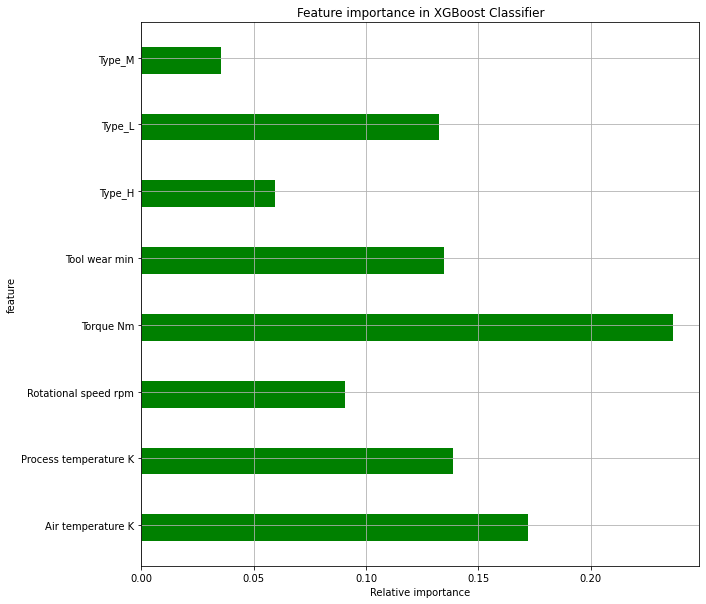

<Figure size 720x720 with 0 Axes>

In [68]:
#modelname.feature_importance_
y = best_bayes.feature_importances_

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(data_train, minor=False)
plt.title('Feature importance in XGBoost Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.grid()
plt.figure(figsize=(10,10))
fig.set_size_inches(10, 10, forward=True)

After using two different approaches for hyperparameter optimisation, it seems that our default model is still the best best performing model and trying different hyperparameter combinations via brute-force grid search and bayesian search did not improve our results. We can see that for both settings torque as an indicator for force on the machine has the highest importance, which is kind of self-explaining. On top of that, the air temperature influences the machine from the outside and can be harmful to the machine. The temperature withing the process seems to be important as well. So, companies have to pay attention to that. Furthermore, we want to mention tool wear as an indicator for intensive usage of a machine, which can cause failures and in particular Type_L. Type_L is the lowest type based on quality, which has the highest impact on the machine in terms of tool wear, as stated in the data discovery part in the beginning.

# VII. Test Set and Mistake Analysis

Since our hyperparameter tuning did not improve our results, we will use the default XGBoost model in the default setting with train+val as training data and evaluate how good the model generalizes on the test set and dive into the failures of our model and understand what is happening.

In [70]:
train_val = pd.concat([data_train, data_val], axis=0)
train_val_target = pd.concat([target_train, target_val], axis=0)

In [76]:
xgb = XGBClassifier()
xgb.fit(train_val, train_val_target)
prediction = xgb.predict(data_test)
f1= f1_score(target_test,prediction, average = 'macro') 
precision = precision_score(target_test,prediction, average = 'macro')
recall = recall_score(target_test,prediction, average = 'macro')
print("The F1-Score on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:42:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1-Score on the validation set: 0.8835
The Precision on the validation set: 0.9234
The Recall on the validation set: 0.8509
Confusion Matrix : 
[[1924    8]
 [  20   48]]


We can see that the model generalizes well with a F1-score on our previous test set, that the model has not seen before. Since the data is generated synthetically (e.g., temperature by random walks), the distribution within the data set is not very different. We will shortly look if the feature importance has changed in comparison to the hyperparameter tuning step.

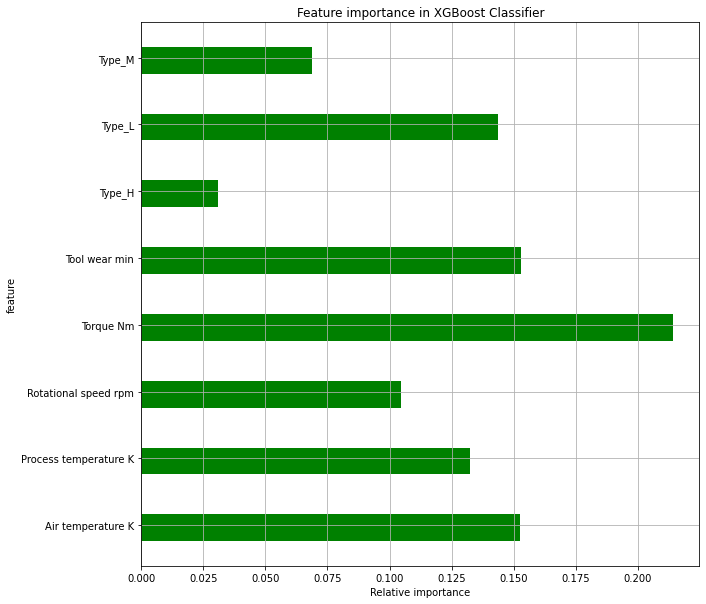

<Figure size 720x720 with 0 Axes>

In [77]:
#modelname.feature_importance_
y = xgb.feature_importances_

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(data_train, minor=False)
plt.title('Feature importance in XGBoost Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.grid()
plt.figure(figsize=(10,10))
fig.set_size_inches(10, 10, forward=True)

We can still see that force represented by torque has the highest importance and impact on our results, while the importance of the temperatures has shrinked a bit in favor of a higher importance for tool wear and type_L. This might be explained by the fact that the temperatures are generated by random walks and therefore maybe not fully reliable for a productive environment (see picture below). However, these changes are not too substantial and the reasoning from above still holds.

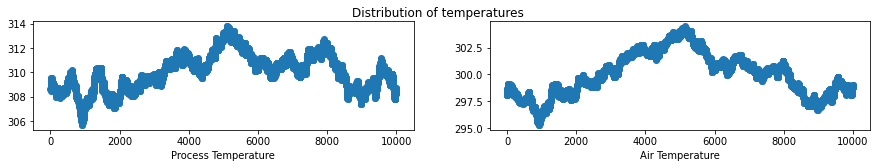

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15,2))
fig.suptitle('Distribution of temperatures')
ax1.scatter(df.index, df['Process temperature K'])
ax1.set_xlabel('Process Temperature')
ax2.scatter(df.index, df['Air temperature K'])
ax2.set_xlabel('Air Temperature')
plt.show()

As a last step, we will have a look at the values that were predicted wrongly by the XGBoost algorithm to understand if we can 
derive insights from that. We create a dataframe with the target and the predictions to be able to check the differences.

In [93]:
df_comparison = pd.concat([data_test.reset_index(),target_test.reset_index(drop=True), pd.Series(prediction)], axis=1)
df_comparison.rename(columns={0 :'Prediction'}, inplace=True )

In [94]:
df_comparison

,index,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Type_H,Type_L,Type_M,Target,Prediction
0,2997,0.247057,-0.138618,-1.083375,2.269560,0.717812,0.0,1.0,0.0,0,0
1,4871,1.849553,1.620806,-0.145587,0.010628,0.435504,0.0,1.0,0.0,0,0
2,3858,1.248617,0.944104,0.111189,-0.239254,1.596103,0.0,1.0,0.0,0,0
3,951,-2.206766,-2.507073,-0.167915,-0.419169,-0.740779,1.0,0.0,0.0,0,0
4,6463,0.247057,-0.003278,-1.010808,2.039668,-0.082060,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,1686,-1.054972,-1.830372,0.691725,-1.128833,-1.572019,1.0,0.0,0.0,0,0
1996,6952,0.397291,0.876434,-0.229318,0.020623,-0.536890,0.0,1.0,0.0,0,0
1997,9954,-0.954816,-1.424351,-0.519586,0.280500,0.215931,0.0,0.0,1.0,0,0
1998,5728,1.198539,1.282455,-0.653556,0.640330,1.360846,0.0,0.0,1.0,0,0


We filter our dataset on all values where target and prediction are not the same to see if we can recognize patterns. Since our test set is scaled, we cannot get real insights from those values. Therefore, we extract the indices where our model predictions were wrong and join the predictions based on those indices with an inner join to the main dataframe to filter only on those indices. Afterwards, we are able to compare those values for example to the original distribution.

In [118]:
#join the wrong predictions to our original dataset based on index
df_predictions = df_comparison[(df_comparison.Target!=df_comparison.Prediction)][['index','Prediction']].set_index('index')
df_wrong_predictions = df.merge(df_predictions, how ='inner',left_index=True, right_index=True)

In [122]:
df[df['Target']==0].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,9661.00,299.97,1.99,295.30,298.30,300.00,301.50,304.50
Process temperature K,9661.00,310.00,1.49,305.70,308.80,310.00,311.10,313.80
Rotational speed rpm,9661.00,1540.26,167.39,1168.00,1429.00,1507.00,1615.00,2695.00
Torque Nm,9661.00,39.63,9.47,12.60,33.10,39.90,46.30,70.00
Tool wear min,9661.00,106.69,62.95,0.00,52.00,107.00,160.00,246.00
Target,9661.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [120]:
df_wrong_predictions[df_wrong_predictions['Target']==0].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,8.00,300.99,1.41,298.80,300.28,301.10,302.20,302.60
Process temperature K,8.00,310.69,0.92,309.20,310.27,310.70,311.03,312.10
Rotational speed rpm,8.00,1619.88,490.31,1222.00,1335.00,1392.00,1694.25,2514.00
Torque Nm,8.00,41.24,19.16,13.40,30.10,47.60,49.37,70.00
Tool wear min,8.00,150.88,83.33,36.00,60.00,207.50,211.25,215.00
Target,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Prediction,8.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


We can see that the distributions differ. If our target was zero and the prediction was wrong, the means are higher and in some cases like tool wear a lot higher than for the overall target 0 in the dataset. We already know that higher values of torque and tool wear lead to a higher chance of possible failures. That information could be an indicator why it is failing in some cases for original target 0. It could be the case that a failure might happen in a short period afterwards.

In [123]:
df[df['Target']==1].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,339.00,300.89,2.07,295.60,299.10,301.60,302.50,304.40
Process temperature K,339.00,310.29,1.36,306.10,309.50,310.40,311.20,313.70
Rotational speed rpm,339.00,1496.49,384.94,1181.00,1326.50,1365.00,1421.50,2886.00
Torque Nm,339.00,50.17,16.37,3.80,45.95,53.70,61.20,76.60
Tool wear min,339.00,143.78,72.76,0.00,84.50,165.00,207.50,253.00
Target,339.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


In [121]:
df_wrong_predictions[df_wrong_predictions['Target']==1].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,20.00,300.43,2.06,297.00,298.40,300.65,302.02,303.70
Process temperature K,20.00,310.03,1.52,307.30,309.20,310.10,311.00,312.40
Rotational speed rpm,20.00,1474.00,198.45,1259.00,1362.25,1392.00,1551.25,1996.00
Torque Nm,20.00,45.54,13.84,19.80,35.60,47.75,57.07,63.90
Tool wear min,20.00,160.65,72.04,20.00,98.50,199.00,211.75,246.00
Target,20.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
Prediction,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


For the case that the original target was a 1, we see that the means of torque and rotational speed are quite smaller for the wrong predictions than for the overall distribution for target 1. Again, we already know that especially torque has the highest impact on the classification and is an indicator for possible failures. For this reason, the algorithm uses the high importance of torque to classify those failures as non-failures.

For concluding this part, we will look into the different rows that have been classified wrong for the specific target to see if something anomal stands out directly.

In [125]:
df_wrong_predictions[df_wrong_predictions['Target']==0]

,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,Prediction
1418,L,298.8,309.9,1320,47.4,210,0,1
2080,L,299.3,309.2,2280,15.4,207,0,1
3794,M,302.2,310.8,1356,48.3,36,0,1
4231,L,302.2,310.8,1340,47.8,54,0,1
5489,L,302.6,312.1,1499,35.0,215,0,1
6612,L,301.6,310.6,1222,70.0,62,0,1
7086,L,300.6,310.4,2514,13.4,215,0,1
7677,L,300.6,311.7,1428,52.6,208,0,1


We can see no real tendency towards specific values. But, we can recognize that there are some outliers in different columns that could explain the wrong prediction. For example, we have two extremly high values for rotational speed (index 2080 and 7086) that could be responsible for the wrong prediction. In those examples tool wear is extremly low, which is normally an indicator for non-failure. The same can be said for example for index 6612, where we have an extremly high value for torque.

In [124]:
df_wrong_predictions[df_wrong_predictions['Target']==1]

,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,Prediction
1085,L,297.0,307.8,1385,56.4,202,1,0
1833,L,297.8,307.3,1327,61.0,186,1,0
1996,M,298.4,308.0,1416,38.2,198,1,0
2671,M,299.7,309.3,1399,41.9,221,1,0
2864,H,300.6,309.4,1380,47.6,246,1,0
2941,M,300.7,309.6,1996,19.8,203,1,0
3695,L,302.2,311.3,1530,37.3,207,1,0
3806,M,302.3,310.9,1360,44.0,67,1,0
4034,L,302.0,310.8,1615,29.0,235,1,0
4078,H,302.1,310.7,1294,62.4,101,1,0


For target 1, as already pointed out, one can see that there are some values that have a really low torque and are therefore classified as 0. We can also investigate that there are some combinations with higher torque but extremly low tool wear (e.g., index 4130 and 4307), which can be an indicator why it was predicted as 0. However, there is no overall tendency that can be identified for those wrong classification.

## VIII. Summary and Outlook

In the following, we will give a short summary over all the finding and an outlook what could be further possibilites for the processing of the dataset.

Summary:

- Good results overall in classification with best model f1 = 0.8835 on test.
- Synthetic dataset without any NA's.
- XGBoost outperforms others by minimum 5 pp.
- Dropping correlated features results in worse results.
- Further feature generation did not improve the results of XGBoost anymore, but it did for example for the MLP classifier.
- Default settings worked best for XGBoost, hyperparameter tuning did not improve it (two methods used).
- Wrong classifications might be explained by outliers, but there is no clear tendency.

Outlook:

- Upsampling the minority class in train data to check if it improves the result.
- Further tests for possible features to generate (for example brute force linear combinations of features via featuretools package)
- Check if failure happens in a short period after predictions that have been classified as 1 mistakenly.
- Outlier removal via e.g., standard statistics or algorithms like isolation forest to see if the results improve.